In [240]:
import torch


def check_cuda():
    if torch.cuda.is_available():
        print("CUDA is available.")
        print(f"Number of GPUs available: {torch.cuda.device_count()}")
        print(f"Current GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
        print(f"CUDA version: {torch.version.cuda}")
    else:
        print("CUDA is not available.")


check_cuda()

CUDA is available.
Number of GPUs available: 1
Current GPU: NVIDIA GeForce RTX 3090
CUDA version: 11.8


In [241]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import copy
from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.primitives.asymmetric import dh
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
import pickle
import sys

import os



In [242]:

from datetime import datetime

# Get the current timestamp
current_timestamp = datetime.now()

# Format the timestamp in a human-readable form
folder_path = current_timestamp.strftime("%d_%H_%M")
fp = f"models/{folder_path}"
if not os.path.exists(fp):
	os.makedirs(fp)


In [243]:
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [244]:
df = pd.read_csv("drone/class_dict_seg.csv")

In [245]:
clients = [0 , 1 , 2]
no_clients = len(clients)
epochs = 100

In [246]:
image_path = "drone/dataset/semantic_drone_dataset/label_images_semantic"
original_image_path = "drone/dataset/semantic_drone_dataset/original_images"

In [247]:
files = os.listdir(image_path)

# Filter out only the image files (assuming image files have extensions like .jpg, .png, etc.)
image_files = [
	file for file in files if file.endswith((".jpg", ".jpeg", ".png", ".gif", ".bmp"))
]
image_files = sorted(image_files)

# list o image_paths
image_list = []
# Print the list of image files
for image_file in image_files:
	image_list.append(image_path + "/" + image_file)


files_2 = os.listdir(original_image_path)
# Filter out only the image files (assuming image files have extensions like .jpg, .png, etc.)
image_files = [
	file for file in files_2 if file.endswith((".jpg", ".jpeg", ".png", ".gif", ".bmp"))
]
image_files = sorted(image_files)

# list o image_paths
original_image_list = []
# Print the list of image files
for image_file in image_files:
	original_image_list.append(original_image_path + "/" + image_file)

In [248]:
IMAGE_PATH = "drone/dataset/semantic_drone_dataset/original_images"
MASK_PATH = "drone/dataset/semantic_drone_dataset/label_images_semantic"

In [249]:
n_classes = 23


def create_df():
	name = []
	for dirname, _, filenames in os.walk(IMAGE_PATH):
		for filename in filenames:
			name.append(filename.split(".")[0])

	return pd.DataFrame({"id": name}, index=np.arange(0, len(name)))


df = create_df()
print("Total Images: ", len(df))

Total Images:  400


In [250]:
df.iloc[0]

id    515
Name: 0, dtype: object

In [251]:
# spliting the data for traning , testing and validation
X_trainval, X_test = train_test_split(df["id"].values, test_size=0.1, random_state=42)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=42)

In [252]:
split_train = [X_train[i*len(X_train)//no_clients:(i+1)*len(X_train)//no_clients] for i in range(no_clients)]
split_val = [X_val[i*len(X_val)//no_clients:(i+1)*len(X_val)//no_clients] for i in range(no_clients)]

In [253]:
len(split_train[0])

102

In [254]:
class DroneDataset(Dataset):

	def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
		self.img_path = img_path
		self.mask_path = mask_path
		self.X = X
		self.transform = transform
		self.patches = patch
		self.mean = mean
		self.std = std

	def __len__(self):
		return len(self.X)

	def __getitem__(self, idx):
		img_full_path = os.path.join(self.img_path, self.X[idx] + ".jpg")
		mask_full_path = os.path.join(self.mask_path, self.X[idx] + ".png")

		# Load the image and mask
		img = cv2.imread(img_full_path)
		if img is None:
			raise FileNotFoundError(f"Image not found at {img_full_path}")

		mask = cv2.imread(mask_full_path, cv2.IMREAD_GRAYSCALE)
		if mask is None:
			raise FileNotFoundError(f"Mask not found at {mask_full_path}")

		# Convert color from BGR to RGB
		img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

		if self.transform is not None:
			aug = self.transform(image=img, mask=mask)
			img = Image.fromarray(aug["image"])
			mask = aug["mask"]

		if self.transform is None:
			img = Image.fromarray(img)

		t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
		img = t(img)
		mask = torch.from_numpy(mask).long()

		if self.patches:
			img, mask = self.tiles(img, mask)

		return img, mask

	def tiles(self, img, mask):

		img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
		img_patches = img_patches.contiguous().view(3, -1, 512, 768)
		img_patches = img_patches.permute(1, 0, 2, 3)

		mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
		mask_patches = mask_patches.contiguous().view(-1, 512, 768)

		return img_patches, mask_patches

In [255]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

t_train = A.Compose(
	[
		A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
		A.HorizontalFlip(),
		A.VerticalFlip(),
		A.GridDistortion(p=0.2),
		A.RandomBrightnessContrast((0, 0.5), (0, 0.5)),
		A.GaussNoise(),
	]
)

t_val = A.Compose(
	[
		A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
		A.HorizontalFlip(),
		A.GridDistortion(p=0.2),
	]
)

# datasets
train_set = DroneDataset(
	IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False
)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

# dataloader
batch_size = 1

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [256]:
# datasets
train_loaders = []
val_loaders = [] 
for i in range(no_clients):
	b_train = split_train[i]
	b_val = split_val[i]
	train_set = DroneDataset(
		IMAGE_PATH, MASK_PATH, b_train, mean, std, t_train, patch=False
	)
	val_set = DroneDataset(IMAGE_PATH, MASK_PATH, b_val, mean, std, t_val, patch=False)

	# dataloader
	batch_size = 1

	train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
	val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
	train_loaders.append(train_loader)
	val_loaders.append(val_loader)

In [257]:
models = []
for i in range(no_clients):
	model = smp.Unet(
		encoder_name="resnet34",
		encoder_weights="imagenet",
		in_channels=3,
		classes=n_classes,
	)
	models.append(model)

In [258]:
def pixel_accuracy(output, mask):
	with torch.no_grad():
		output = torch.argmax(F.softmax(output, dim=1), dim=1)
		correct = torch.eq(output, mask).int()
		accuracy = float(correct.sum()) / float(correct.numel())
	return accuracy

In [259]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
	with torch.no_grad():
		pred_mask = F.softmax(pred_mask, dim=1)
		pred_mask = torch.argmax(pred_mask, dim=1)
		pred_mask = pred_mask.contiguous().view(-1)
		mask = mask.contiguous().view(-1)

		iou_per_class = []
		for clas in range(0, n_classes):  # loop per pixel class
			true_class = pred_mask == clas
			true_label = mask == clas

			if true_label.long().sum().item() == 0:  # no exist label in this loop
				iou_per_class.append(np.nan)
			else:
				intersect = (
					torch.logical_and(true_class, true_label).sum().float().item()
				)
				union = torch.logical_or(true_class, true_label).sum().float().item()

				iou = (intersect + smooth) / (union + smooth)
				iou_per_class.append(iou)
		return np.nanmean(iou_per_class)

In [260]:
import numpy as np
import matplotlib.pyplot as plt


def plot(pred_masks, true_masks):
	n_classes = len(np.unique(true_masks))  # Number of unique classes
	class_colors = plt.cm.tab20.colors  # Colors for different classes

	n_images = pred_masks.shape[0]  # Number of images

	# Create subplots outside the loop
	fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))

	for i in range(n_images):
		im_pred = axes[i, 0].imshow(
			pred_masks[i, 0], cmap="tab20", vmin=0, vmax=n_classes - 1
		)  # Assuming single channel masks
		axes[i, 0].set_title("Predicted Mask")
		axes[i, 0].set_axis_off()
		fig.colorbar(im_pred, ax=axes[i, 0], label="Predicted Class")

		im_true = axes[i, 1].imshow(
			true_masks[i], cmap="tab20", vmin=0, vmax=n_classes - 1
		)
		axes[i, 1].set_title("True Mask")
		axes[i, 1].set_axis_off()
		fig.colorbar(im_true, ax=axes[i, 1], label="True Class")

	plt.tight_layout()
	plt.show()

In [261]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import time
from tqdm import tqdm
import learn2learn as l2l


def get_lr(optimizer):
	for param_group in optimizer.param_groups:
		return param_group["lr"]


def fit(
	epochs,
	model,
	train_loader,
	val_loader,
	criterion,
	optimizer,
	scheduler,
	patch=False,
	adaptation_steps=5,
	inner_lr=0.01,
):
	torch.cuda.empty_cache()
	train_losses = []
	test_losses = []
	val_iou = []
	val_acc = []
	train_iou = []
	train_acc = []
	lrs = []
	min_loss = np.inf
	decrease = 1
	not_improve = 0

	model.to(device)
	fit_time = time.time()
	for e in range(epochs):
		since = time.time()
		running_loss = 0
		iou_score = 0
		accuracy = 0

		# training loop
		model.train()
		for i, data in enumerate(tqdm(train_loader)):
			# training phase
			image_tiles, mask_tiles = data
			if patch:
				bs, n_tiles, c, h, w = image_tiles.size()
				image_tiles = image_tiles.view(-1, c, h, w)
				mask_tiles = mask_tiles.view(-1, h, w)

			image = image_tiles.to(device)
			mask = mask_tiles.to(device)

			# Meta-learning with MAML
			optimizer.zero_grad()

			# Clone the model for inner-loop updates
			learner = l2l.algorithms.MAML(model, lr=inner_lr).clone()

			# Inner loop: Adaptation
			for step in range(adaptation_steps):
				output = learner(image)
				loss = criterion(output, mask)
				learner.adapt(loss)

			# Meta-update
			output = learner(image)
			loss = criterion(output, mask)
			loss.backward()
			optimizer.step()

			# Step the learning rate
			lrs.append(get_lr(optimizer))
			scheduler.step()

			running_loss += loss.item()
			# Evaluation metrics
			iou_score += mIoU(output, mask)
			accuracy += pixel_accuracy(output, mask)

		# Validation loop
		model.eval()
		test_loss = 0
		test_accuracy = 0
		val_iou_score = 0
		with torch.no_grad():
			for i, data in enumerate(tqdm(val_loader)):
				image_tiles, mask_tiles = data
				if patch:
					bs, n_tiles, c, h, w = image_tiles.size()
					image_tiles = image_tiles.view(-1, c, h, w)
					mask_tiles = mask_tiles.view(-1, h, w)

				image = image_tiles.to(device)
				mask = mask_tiles.to(device)

				output = model(image)
				val_iou_score += mIoU(output, mask)
				test_accuracy += pixel_accuracy(output, mask)
				loss = criterion(output, mask)
				test_loss += loss.item()

		# Calculate mean for each batch
		train_losses.append(running_loss / len(train_loader))
		test_losses.append(test_loss / len(val_loader))

		if min_loss > (test_loss / len(val_loader)):
			print(
				"Loss Decreasing.. {:.3f} >> {:.3f} ".format(
					min_loss, (test_loss / len(val_loader))
				)
			)
			min_loss = test_loss / len(val_loader)
			decrease += 1
			if decrease % 5 == 0:
				print("saving model...")
				torch.save(
					model,
					"Unet-Mobilenet_v2_mIoU-{:.3f}.pt".format(
						val_iou_score / len(val_loader)
					),
				)

		if (test_loss / len(val_loader)) > min_loss:
			not_improve += 1
			min_loss = test_loss / len(val_loader)
			print(f"Loss Not Decrease for {not_improve} time")
			if not_improve == 7:
				print("Loss not decrease for 7 times, Stop Training")
				break

		# Update metrics
		val_iou.append(val_iou_score / len(val_loader))
		train_iou.append(iou_score / len(train_loader))
		train_acc.append(accuracy / len(train_loader))
		val_acc.append(test_accuracy / len(val_loader))
		print(
			"Epoch:{}/{}..".format(e + 1, epochs),
			"Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
			"Val Loss: {:.3f}..".format(test_loss / len(val_loader)),
			"Train mIoU:{:.3f}..".format(iou_score / len(train_loader)),
			"Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
			"Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
			"Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)),
			"Time: {:.2f}m".format((time.time() - since) / 60),
		)

	history = {
		"train_loss": train_losses,
		"val_loss": test_losses,
		"train_miou": train_iou,
		"val_miou": val_iou,
		"train_acc": train_acc,
		"val_acc": val_acc,
		"lrs": lrs,
	}
	print("Total time: {:.2f} m".format((time.time() - fit_time) / 60))
	return history

In [262]:
# max_lr = 1e-3
# epoch = 2
# weight_decay = 1e-4

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
# sched = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader)
# )

# history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

In [263]:
def fed_train(model):
	history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)
	return model , history

In [264]:
import numpy as np
from Pyfhel import Pyfhel

HE = Pyfhel()
ckks_params = {
	"scheme": "CKKS",
	"n": 2**14,  # Polynomial modulus degree. For CKKS, n/2 values can be
	"scale": 2**30,  # All the encodings will use it for float->fixed point
	"qi_sizes": [60, 30, 30, 30, 60],  # Number of bits of each prime in the chain.
}
HE.contextGen(**ckks_params)  # Generate context for ckks scheme
HE.keyGen()  # Key Generation: generates a pair of public/secret keys
HE.rotateKeyGen()

In [265]:
def generate_diffie_hellman_parameters():
	parameters = dh.generate_parameters(generator=2, key_size=512)
	return parameters


def generate_diffie_hellman_keys(parameters):
	private_key = parameters.generate_private_key()
	public_key = private_key.public_key()
	return private_key, public_key


def derive_key(private_key, peer_public_key):
	shared_key = private_key.exchange(peer_public_key)
	derived_key = HKDF(
		algorithm=hashes.SHA256(),
		length=32,
		salt=None,
		info=b"handshake data",
	).derive(shared_key)
	return derived_key


def encrypt_message_AES(key, message):
	serialized_obj = pickle.dumps(message)
	cipher = Cipher(algorithms.AES(key), modes.ECB())
	encryptor = cipher.encryptor()
	padded_obj = serialized_obj + b" " * (16 - len(serialized_obj) % 16)
	ciphertext = encryptor.update(padded_obj) + encryptor.finalize()
	return ciphertext


def decrypt_message_AES(key, ciphertext):
	cipher = Cipher(algorithms.AES(key), modes.ECB())
	decryptor = cipher.decryptor()
	padded_obj = decryptor.update(ciphertext) + decryptor.finalize()
	serialized_obj = padded_obj.rstrip(b" ")
	obj = pickle.loads(serialized_obj)
	return obj


def setup_AES():
	num_clients = len(clients)
	parameters = generate_diffie_hellman_parameters()
	server_private_key, server_public_key = generate_diffie_hellman_keys(parameters)
	client_keys = [generate_diffie_hellman_keys(parameters) for _ in range(num_clients)]
	shared_keys = [
		derive_key(server_private_key, client_public_key)
		for _, client_public_key in client_keys
	]
	client_shared_keys = [
		derive_key(client_private_key, server_public_key)
		for client_private_key, _ in client_keys
	]

	return client_keys, shared_keys, client_shared_keys

client_keys, shared_keys, client_shared_keys = setup_AES()

In [266]:
def load_weights(model, weights):
	with torch.no_grad(): 
		for param, weight in zip(model.parameters(), weights):
			param.copy_(torch.tensor(weight))
	return model

In [267]:
def get_weights(model):
	return [param.cpu().detach().numpy() for param in model.parameters()]

In [268]:
def aggregate_wt(encypted_cwts):
	# cwts = []
	# for i, ecwt in enumerate(encypted_cwts):
	# 	cwts.append(decrypt_message_AES(shared_keys[i], ecwt))
	cwts = encypted_cwts
	resmodel = []
	for j in range(len(cwts[0])):  # for layers
		layer = []
		for k in range(len(cwts[0][j])):  # for chunks
			tmp = cwts[0][j][k].copy()
			for i in range(1, len(cwts)):  # for clients
				tmp = tmp + cwts[i][j][k]
			tmp = tmp / len(cwts)
			layer.append(tmp)
		resmodel.append(layer)

	res = [resmodel.copy() for _ in range(len(clients))]
	return res

In [269]:
def encrypt_wt(wtarray, i):
	cwt = []
	for layer in wtarray:
		flat_array = layer.astype(np.float64).flatten()

		chunks = np.array_split(flat_array, (len(flat_array) + 2**13 - 1) // 2**13)
		clayer = []
		for chunk in chunks:
			ptxt = HE.encodeFrac(chunk)
			ctxt = HE.encryptPtxt(ptxt)
			clayer.append(ctxt)
		cwt.append(clayer.copy())
	# ciphertext = encrypt_message_AES(client_shared_keys[i], cwt)
	# return ciphertext
	return cwt

In [270]:
def decrypt_weights(res):
	decrypted_weights = []
	for client_weights, model in zip(res, models):
		decrypted_client_weights = []
		wtarray = get_weights(model)
		for layer_weights, layer in zip(client_weights, wtarray):
			decrypted_layer_weights = []
			flat_array = layer.astype(np.float64).flatten()
			chunks = np.array_split(flat_array, (len(flat_array) + 2**13 - 1) // 2**13)
			for chunk, encrypted_chunk in zip(chunks, layer_weights):
				decrypted_chunk = HE.decryptFrac(encrypted_chunk)
				original_chunk_size = len(chunk)
				decrypted_chunk = decrypted_chunk[:original_chunk_size]
				decrypted_layer_weights.append(decrypted_chunk)
			decrypted_layer_weights = np.concatenate(decrypted_layer_weights, axis=0)
			decrypted_layer_weights = decrypted_layer_weights.reshape(layer.shape)
			decrypted_client_weights.append(decrypted_layer_weights)
		decrypted_weights.append(decrypted_client_weights)
	return decrypted_weights

In [271]:
max_lr = 0.01
weight_decay = 0.01

In [272]:
# histories = []
# cwts = [encrypt_wt(get_weights(model), i) for i, model in enumerate(models)]
# print("Initial encrypted weights generated for all clients.")

# for e in range(epochs):
#     print(f"Epoch {e+1}/{epochs} started")
	
#     cwts = aggregate_wt(cwts)
#     print(f"Aggregated encrypted weights after epoch {e+1}")
	
#     wts = decrypt_weights(cwts)
#     print(f"Decrypted weights after aggregation for epoch {e+1}")
	
#     cwts = []
#     epoch_histories = []
	
#     for i in range(no_clients):
#         print(f"Client {i} preparing to load weights and datasets for epoch {e+1}")
		
#         wt = wts[i]
#         model = load_weights(models[i], wt)
		
#         train_loader = train_loaders[i]
#         val_loader = val_loaders[i]
		
#         criterion = nn.CrossEntropyLoss()
#         optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
#         sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=1, steps_per_epoch=len(train_loader))
		
#         print(f"Client {i} Epoch {e+1} started")
		
#         history = fit(1, model, train_loader, val_loader, criterion, optimizer, sched)
		
#         epoch_histories.append(history)
#         print(f"Client {i} Epoch {e+1} completed with history: {history}")
		
#         wtarray = get_weights(model)
#         cwts.append(encrypt_wt(wtarray, i))
#         print(f"Client {i} weights encrypted and added to cwts for epoch {e+1}")

#     histories.append(epoch_histories)
#     print(f"Epoch {e+1} completed and histories updated")

# print("Training completed.")


In [273]:
# from tqdm import tqdm

# histories = []
# previous_losses = {i: [] for i in range(no_clients)}

# cwts = [encrypt_wt(get_weights(model), i) for i, model in enumerate(models)]
# print("Initial encrypted weights generated for all clients.")

# for e in tqdm(range(epochs), desc="Epochs", colour='green'):
#     print(f"Epoch {e+1}/{epochs} started")
	
#     cwts = aggregate_wt(cwts)
#     print(f"Aggregated encrypted weights after epoch {e+1}")
	
#     wts = decrypt_weights(cwts)
#     print(f"Decrypted weights after aggregation for epoch {e+1}")
	
#     cwts = []
#     epoch_histories = []
	
#     for i in range(no_clients):
#         print(f"Client {i} preparing to load weights and datasets for epoch {e+1}")
		
#         wt = wts[i]
#         model = load_weights(models[i], wt)
		
#         train_loader = train_loaders[i]
#         val_loader = val_loaders[i]
		
#         criterion = nn.CrossEntropyLoss()
#         optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
#         sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=1, steps_per_epoch=len(train_loader))
		
#         print(f"Client {i} previous losses before epoch {e+1}: {previous_losses[i]}")
#         print(f"Client {i} Epoch {e+1} started")
		
#         history = fit(1, model, tqdm(train_loader, desc=f"Client {i} Training", colour='blue'), val_loader, criterion, optimizer, sched)
		
#         epoch_histories.append(history)
#         print(f"Client {i} Epoch {e+1} completed with history: {history}")
		
#         previous_losses[i].append({
#             'train_loss': history['train_loss'][-1],
#             'val_loss': history['val_loss'][-1]
#         })
#         print(f"Client {i} previous losses updated: {previous_losses[i]}")
		
#         wtarray = get_weights(model)
#         cwts.append(encrypt_wt(wtarray, i))
#         print(f"Client {i} weights encrypted and added to cwts for epoch {e+1}")

#     histories.append(epoch_histories)
#     print(f"Epoch {e+1} completed and histories updated")

# print("Training completed.")



In [274]:
# # Plotting accuracy over time
# train_accuracies = {i: [] for i in range(no_clients)}
# val_accuracies = {i: [] for i in range(no_clients)}

# for epoch_histories in histories:
#     for i, history in enumerate(epoch_histories):
#         train_accuracies[i].append(history["train_accuracy"][-1])
#         val_accuracies[i].append(history["val_accuracy"][-1])

# plt.figure(figsize=(10, 6))

# for i in range(no_clients):
#     plt.plot(train_accuracies[i], label=f"Client {i} Train Accuracy")
#     plt.plot(val_accuracies[i], label=f"Client {i} Val Accuracy")

# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("Training and Validation Accuracy Over Time")
# plt.legend()
# plt.grid(True)
# plt.show()

In [275]:

# for e, epoch_histories in enumerate(histories):
#     print(f"Epoch {e+1} histories:")
#     for i, history in enumerate(epoch_histories):
#         print(f"  Client {i}: {history}")

In [276]:
def fit(
	epochs,
	model,
	train_loader,
	val_loader,
	criterion,
	optimizer,
	scheduler,
	patch=False,
	adaptation_steps=5,
	inner_lr=0.01,
):
	torch.cuda.empty_cache()
	train_losses = []
	test_losses = []
	val_iou = []
	val_acc = []
	train_iou = []
	train_acc = []
	lrs = []
	min_loss = np.inf
	decrease = 1
	not_improve = 0

	model.to(device)
	fit_time = time.time()
	for e in range(epochs):
		since = time.time()
		running_loss = 0
		iou_score = 0
		accuracy = 0

		# training loop
		model.train()
		for i, data in enumerate(tqdm(train_loader)):
			# training phase
			image_tiles, mask_tiles = data
			if patch:
				bs, n_tiles, c, h, w = image_tiles.size()
				image_tiles = image_tiles.view(-1, c, h, w)
				mask_tiles = mask_tiles.view(-1, h, w)

			image = image_tiles.to(device)
			mask = mask_tiles.to(device)

			# Meta-learning with MAML
			optimizer.zero_grad()

			# Clone the model for inner-loop updates
			learner = l2l.algorithms.MAML(model, lr=inner_lr).clone()

			# Inner loop: Adaptation
			for step in range(adaptation_steps):
				output = learner(image)
				loss = criterion(output, mask)
				learner.adapt(loss)

			# Meta-update
			output = learner(image)
			loss = criterion(output, mask)
			loss.backward()
			optimizer.step()

			# Step the learning rate
			lrs.append(get_lr(optimizer))
			scheduler.step()

			running_loss += loss.item()
			# Evaluation metrics
			iou_score += mIoU(output, mask)
			accuracy += pixel_accuracy(output, mask)

		# Validation loop
		model.eval()
		test_loss = 0
		test_accuracy = 0
		val_iou_score = 0
		with torch.no_grad():
			for i, data in enumerate(tqdm(val_loader)):
				image_tiles, mask_tiles = data
				if patch:
					bs, n_tiles, c, h, w = image_tiles.size()
					image_tiles = image_tiles.view(-1, c, h, w)
					mask_tiles = mask_tiles.view(-1, h, w)

				image = image_tiles.to(device)
				mask = mask_tiles.to(device)

				output = model(image)
				val_iou_score += mIoU(output, mask)
				test_accuracy += pixel_accuracy(output, mask)
				loss = criterion(output, mask)
				test_loss += loss.item()

		# Calculate mean for each batch
		train_losses.append(running_loss / len(train_loader))
		test_losses.append(test_loss / len(val_loader))

		if min_loss > (test_loss / len(val_loader)):
			print(
				"Loss Decreasing.. {:.3f} >> {:.3f} ".format(
					min_loss, (test_loss / len(val_loader))
				)
			)
			min_loss = test_loss / len(val_loader)
			decrease += 1
			if decrease % 5 == 0:
				print("saving model...")
				torch.save(
					model,
					"Unet-Mobilenet_v2_mIoU-{:.3f}.pt".format(
						val_iou_score / len(val_loader)
					),
				)

		if (test_loss / len(val_loader)) > min_loss:
			not_improve += 1
			min_loss = test_loss / len(val_loader)
			print(f"Loss Not Decrease for {not_improve} time")
			if not_improve == 7:
				print("Loss not decrease for 7 times, Stop Training")
				break

		# Update metrics
		val_iou.append(val_iou_score / len(val_loader))
		train_iou.append(iou_score / len(train_loader))
		train_acc.append(accuracy / len(train_loader))
		val_acc.append(test_accuracy / len(val_loader))
		print(
			"Epoch:{}/{}..".format(e + 1, epochs),
			"Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
			"Val Loss: {:.3f}..".format(test_loss / len(val_loader)),
			"Train mIoU:{:.3f}..".format(iou_score / len(train_loader)),
			"Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
			"Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
			"Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)),
			"Time: {:.2f}m".format((time.time() - since) / 60),
		)

	history = {
		"train_loss": train_losses,
		"val_loss": test_losses,
		"train_miou": train_iou,
		"val_miou": val_iou,
		"train_acc": train_acc,
		"val_acc": val_acc,
		"lrs": lrs,
	}
	print("Total time: {:.2f} m".format((time.time() - fit_time) / 60))
	return history

In [277]:
import logging
import os
from tqdm import tqdm
import torch
import torch.nn as nn

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Ensure modelsfed folder exists
fp = "modelsfed"
os.makedirs(fp, exist_ok=True)

histories = []
previous_losses = {i: [] for i in range(no_clients)}

train_losses = [[] for _ in range(no_clients)]
train_accuracies = [[] for _ in range(no_clients)]

cwts = [encrypt_wt(get_weights(model), i) for i, model in enumerate(models)]
logger.info("Initial encrypted weights generated for all clients.")

for e in tqdm(range(epochs), desc="Epochs", colour="green"):
    logger.info(f"Epoch {e+1}/{epochs} started")
    cwts = aggregate_wt(cwts)
    logger.info(f"Aggregated encrypted weights after epoch {e+1}")
    wts = decrypt_weights(cwts)
    logger.info(f"Decrypted weights after aggregation for epoch {e+1}")

    cwts = []
    epoch_histories = []

    for i in range(no_clients):
        logger.debug(f"Client {i} preparing for epoch {e+1}")
        wt = wts[i]
        model = load_weights(models[i], wt)

        # Save weights for client 0 before loading them
        if i == 0:
            torch.save(model.state_dict(), f"{fp}/client0_epoch{e}_before_load.pth")

        if (e % 5 == 0) and i == 0:
            torch.save(model.state_dict(), f"{fp}/{e}_model.pth")

        train_loader = train_loaders[i]
        val_loader = val_loaders[i]

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(
            model.parameters(), lr=max_lr, weight_decay=weight_decay
        )
        sched = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr, epochs=1, steps_per_epoch=len(train_loader)
        )

        logger.debug(f"Client {i} previous losses: {previous_losses[i]}")
        history = fit(
            1,
            model,
            tqdm(train_loader, desc=f"Client {i} Training", colour="blue"),
            val_loader,
            criterion,
            optimizer,
            sched,
        )
        epoch_histories.append(history)

        previous_losses[i].append(
            {
                "train_loss": history["train_loss"][-1],
                "train_acc": history["train_acc"][-1],
            }
        )
        logger.info(
            f"Client {i} - Epoch {e+1}: "
            f"Train Loss: {history['train_loss'][-1]:.4f}, "
            f"Train Acc: {history['train_acc'][-1]:.4f}"
        )

        train_losses[i].append(history["train_loss"][-1])
        train_accuracies[i].append(history["train_acc"][-1])

        wtarray = get_weights(model)
        cwts.append(encrypt_wt(wtarray, i))
        logger.debug(f"Client {i} weights encrypted for epoch {e+1}")

    histories.append(epoch_histories)
    logger.info(f"Epoch {e+1} completed")

    # Save the training losses and accuracies in array of arrays format after each epoch
    with open(f"{fp}/train_losses.txt", "w") as f:
        f.write(f"{train_losses}\n")

    with open(f"{fp}/train_accuracies.txt", "w") as f:
        f.write(f"{train_accuracies}\n")

logger.info("Training completed.")

# Saving the final model weights and training metrics
torch.save(models[0].state_dict(), f"{fp}/final_model.pth")

INFO:__main__:Initial encrypted weights generated for all clients.
Epochs:   0%|          | 0/100 [00:00<?, ?it/s]INFO:__main__:Epoch 1/100 started
INFO:__main__:Aggregated encrypted weights after epoch 1
INFO:__main__:Decrypted weights after aggregation for epoch 1







































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 0 - Epoch 1: Train Loss: 2.0094, Train Acc: 0.4816


Loss Decreasing.. inf >> 3.467 
Epoch:1/1.. Train Loss: 2.009.. Val Loss: 3.467.. Train mIoU:0.078.. Val mIoU: 0.020.. Train Acc:0.482.. Val Acc:0.167.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.82it/s]
INFO:__main__:Client 1 - Epoch 1: Train Loss: 2.7225, Train Acc: 0.2496


Loss Decreasing.. inf >> 9.647 
Epoch:1/1.. Train Loss: 2.723.. Val Loss: 9.647.. Train mIoU:0.050.. Val mIoU: 0.039.. Train Acc:0.250.. Val Acc:0.322.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 1: Train Loss: 1.7226, Train Acc: 0.5864


Loss Decreasing.. inf >> 1.846 
Epoch:1/1.. Train Loss: 1.723.. Val Loss: 1.846.. Train mIoU:0.117.. Val mIoU: 0.088.. Train Acc:0.586.. Val Acc:0.481.. Time: 4.31m
Total time: 4.31 m


INFO:__main__:Epoch 1 completed
Epochs:   1%|          | 1/100 [14:42<24:16:20, 882.63s/it]INFO:__main__:Epoch 2/100 started
INFO:__main__:Aggregated encrypted weights after epoch 2
INFO:__main__:Decrypted weights after aggregation for epoch 2







































































































100%|██████████| 18/18 [00:06<00:00,  2.79it/s]
INFO:__main__:Client 0 - Epoch 2: Train Loss: 2.3229, Train Acc: 0.4033


Loss Decreasing.. inf >> 4.915 
Epoch:1/1.. Train Loss: 2.323.. Val Loss: 4.915.. Train mIoU:0.073.. Val mIoU: 0.011.. Train Acc:0.403.. Val Acc:0.073.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.81it/s]
INFO:__main__:Client 1 - Epoch 2: Train Loss: 2.0085, Train Acc: 0.4385


Loss Decreasing.. inf >> 3.189 
Epoch:1/1.. Train Loss: 2.009.. Val Loss: 3.189.. Train mIoU:0.074.. Val mIoU: 0.021.. Train Acc:0.439.. Val Acc:0.077.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.82it/s]
INFO:__main__:Client 2 - Epoch 2: Train Loss: 2.0393, Train Acc: 0.4420


Loss Decreasing.. inf >> 322.007 
Epoch:1/1.. Train Loss: 2.039.. Val Loss: 322.007.. Train mIoU:0.067.. Val mIoU: 0.023.. Train Acc:0.442.. Val Acc:0.156.. Time: 4.32m
Total time: 4.32 m


INFO:__main__:Epoch 2 completed
Epochs:   2%|▏         | 2/100 [29:26<24:02:28, 883.14s/it]INFO:__main__:Epoch 3/100 started
INFO:__main__:Aggregated encrypted weights after epoch 3
INFO:__main__:Decrypted weights after aggregation for epoch 3







































































































100%|██████████| 18/18 [00:06<00:00,  2.81it/s]
INFO:__main__:Client 0 - Epoch 3: Train Loss: 2.1730, Train Acc: 0.4093


Loss Decreasing.. inf >> 6.853 
Epoch:1/1.. Train Loss: 2.173.. Val Loss: 6.853.. Train mIoU:0.059.. Val mIoU: 0.031.. Train Acc:0.409.. Val Acc:0.229.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.80it/s]
INFO:__main__:Client 1 - Epoch 3: Train Loss: 2.0542, Train Acc: 0.4561


Loss Decreasing.. inf >> 4.495 
Epoch:1/1.. Train Loss: 2.054.. Val Loss: 4.495.. Train mIoU:0.077.. Val mIoU: 0.047.. Train Acc:0.456.. Val Acc:0.282.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
INFO:__main__:Client 2 - Epoch 3: Train Loss: 2.2737, Train Acc: 0.3899


Loss Decreasing.. inf >> 4.199 
Epoch:1/1.. Train Loss: 2.274.. Val Loss: 4.199.. Train mIoU:0.056.. Val mIoU: 0.023.. Train Acc:0.390.. Val Acc:0.158.. Time: 4.32m
Total time: 4.32 m


INFO:__main__:Epoch 3 completed
Epochs:   3%|▎         | 3/100 [44:09<23:47:53, 883.23s/it]INFO:__main__:Epoch 4/100 started
INFO:__main__:Aggregated encrypted weights after epoch 4
INFO:__main__:Decrypted weights after aggregation for epoch 4







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 4: Train Loss: 1.7979, Train Acc: 0.5453


Loss Decreasing.. inf >> 3.446 
Epoch:1/1.. Train Loss: 1.798.. Val Loss: 3.446.. Train mIoU:0.090.. Val mIoU: 0.026.. Train Acc:0.545.. Val Acc:0.156.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 4: Train Loss: 1.8756, Train Acc: 0.5445


Loss Decreasing.. inf >> 4.414 
Epoch:1/1.. Train Loss: 1.876.. Val Loss: 4.414.. Train mIoU:0.084.. Val mIoU: 0.051.. Train Acc:0.544.. Val Acc:0.371.. Time: 4.33m
Total time: 4.33 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 2 - Epoch 4: Train Loss: 1.7004, Train Acc: 0.5389


Loss Decreasing.. inf >> 4.716 
Epoch:1/1.. Train Loss: 1.700.. Val Loss: 4.716.. Train mIoU:0.090.. Val mIoU: 0.076.. Train Acc:0.539.. Val Acc:0.361.. Time: 4.32m
Total time: 4.32 m


INFO:__main__:Epoch 4 completed
Epochs:   4%|▍         | 4/100 [58:52<23:32:52, 883.04s/it]INFO:__main__:Epoch 5/100 started
INFO:__main__:Aggregated encrypted weights after epoch 5
INFO:__main__:Decrypted weights after aggregation for epoch 5







































































































100%|██████████| 18/18 [00:07<00:00,  2.55it/s]
INFO:__main__:Client 0 - Epoch 5: Train Loss: 1.6635, Train Acc: 0.5501


Loss Decreasing.. inf >> 2.511 
Epoch:1/1.. Train Loss: 1.664.. Val Loss: 2.511.. Train mIoU:0.090.. Val mIoU: 0.039.. Train Acc:0.550.. Val Acc:0.245.. Time: 4.40m
Total time: 4.40 m









































































































100%|██████████| 18/18 [00:07<00:00,  2.56it/s]
INFO:__main__:Client 1 - Epoch 5: Train Loss: 1.4435, Train Acc: 0.6267


Loss Decreasing.. inf >> 6.848 
Epoch:1/1.. Train Loss: 1.444.. Val Loss: 6.848.. Train mIoU:0.120.. Val mIoU: 0.081.. Train Acc:0.627.. Val Acc:0.470.. Time: 4.40m
Total time: 4.40 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
INFO:__main__:Client 2 - Epoch 5: Train Loss: 2.0539, Train Acc: 0.4446


Loss Decreasing.. inf >> 2.877 
Epoch:1/1.. Train Loss: 2.054.. Val Loss: 2.877.. Train mIoU:0.070.. Val mIoU: 0.056.. Train Acc:0.445.. Val Acc:0.345.. Time: 4.39m
Total time: 4.39 m


INFO:__main__:Epoch 5 completed
Epochs:   5%|▌         | 5/100 [1:13:48<23:25:51, 887.91s/it]INFO:__main__:Epoch 6/100 started
INFO:__main__:Aggregated encrypted weights after epoch 6
INFO:__main__:Decrypted weights after aggregation for epoch 6







































































































100%|██████████| 18/18 [00:06<00:00,  2.81it/s]
INFO:__main__:Client 0 - Epoch 6: Train Loss: 2.0806, Train Acc: 0.5008


Loss Decreasing.. inf >> 77.514 
Epoch:1/1.. Train Loss: 2.081.. Val Loss: 77.514.. Train mIoU:0.084.. Val mIoU: 0.048.. Train Acc:0.501.. Val Acc:0.321.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 6: Train Loss: 1.6383, Train Acc: 0.5695


Loss Decreasing.. inf >> 2.216 
Epoch:1/1.. Train Loss: 1.638.. Val Loss: 2.216.. Train mIoU:0.098.. Val mIoU: 0.056.. Train Acc:0.569.. Val Acc:0.390.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 6: Train Loss: 1.9928, Train Acc: 0.5002


Loss Decreasing.. inf >> 4.098 
Epoch:1/1.. Train Loss: 1.993.. Val Loss: 4.098.. Train mIoU:0.088.. Val mIoU: 0.049.. Train Acc:0.500.. Val Acc:0.273.. Time: 4.32m
Total time: 4.32 m


INFO:__main__:Epoch 6 completed
Epochs:   6%|▌         | 6/100 [1:28:31<23:08:21, 886.18s/it]INFO:__main__:Epoch 7/100 started
INFO:__main__:Aggregated encrypted weights after epoch 7
INFO:__main__:Decrypted weights after aggregation for epoch 7







































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 0 - Epoch 7: Train Loss: 1.3321, Train Acc: 0.6493


Loss Decreasing.. inf >> 3.115 
Epoch:1/1.. Train Loss: 1.332.. Val Loss: 3.115.. Train mIoU:0.132.. Val mIoU: 0.052.. Train Acc:0.649.. Val Acc:0.269.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 7: Train Loss: 1.4801, Train Acc: 0.6122


Loss Decreasing.. inf >> 3.340 
Epoch:1/1.. Train Loss: 1.480.. Val Loss: 3.340.. Train mIoU:0.113.. Val mIoU: 0.063.. Train Acc:0.612.. Val Acc:0.441.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 7: Train Loss: 1.4558, Train Acc: 0.6035


Loss Decreasing.. inf >> 2.021 
Epoch:1/1.. Train Loss: 1.456.. Val Loss: 2.021.. Train mIoU:0.125.. Val mIoU: 0.092.. Train Acc:0.603.. Val Acc:0.448.. Time: 4.32m
Total time: 4.32 m


INFO:__main__:Epoch 7 completed
Epochs:   7%|▋         | 7/100 [1:43:14<22:51:53, 885.09s/it]INFO:__main__:Epoch 8/100 started
INFO:__main__:Aggregated encrypted weights after epoch 8
INFO:__main__:Decrypted weights after aggregation for epoch 8







































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 0 - Epoch 8: Train Loss: 1.2390, Train Acc: 0.6694


Loss Decreasing.. inf >> 2.525 
Epoch:1/1.. Train Loss: 1.239.. Val Loss: 2.525.. Train mIoU:0.142.. Val mIoU: 0.073.. Train Acc:0.669.. Val Acc:0.357.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 1 - Epoch 8: Train Loss: 1.2765, Train Acc: 0.6614


Loss Decreasing.. inf >> 2.712 
Epoch:1/1.. Train Loss: 1.277.. Val Loss: 2.712.. Train mIoU:0.135.. Val mIoU: 0.079.. Train Acc:0.661.. Val Acc:0.359.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 8: Train Loss: 1.5245, Train Acc: 0.5945


Loss Decreasing.. inf >> 2.088 
Epoch:1/1.. Train Loss: 1.524.. Val Loss: 2.088.. Train mIoU:0.121.. Val mIoU: 0.086.. Train Acc:0.594.. Val Acc:0.366.. Time: 4.32m
Total time: 4.32 m


INFO:__main__:Epoch 8 completed
Epochs:   8%|▊         | 8/100 [1:57:55<22:35:11, 883.82s/it]INFO:__main__:Epoch 9/100 started
INFO:__main__:Aggregated encrypted weights after epoch 9
INFO:__main__:Decrypted weights after aggregation for epoch 9







































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
INFO:__main__:Client 0 - Epoch 9: Train Loss: 3.1162, Train Acc: 0.3898


Loss Decreasing.. inf >> 8.523 
Epoch:1/1.. Train Loss: 3.116.. Val Loss: 8.523.. Train mIoU:0.085.. Val mIoU: 0.014.. Train Acc:0.390.. Val Acc:0.042.. Time: 4.38m
Total time: 4.38 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
INFO:__main__:Client 1 - Epoch 9: Train Loss: 1.1674, Train Acc: 0.6871


Loss Decreasing.. inf >> 2.555 
Epoch:1/1.. Train Loss: 1.167.. Val Loss: 2.555.. Train mIoU:0.156.. Val mIoU: 0.089.. Train Acc:0.687.. Val Acc:0.469.. Time: 4.38m
Total time: 4.38 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.65it/s]
INFO:__main__:Client 2 - Epoch 9: Train Loss: 1.4109, Train Acc: 0.6055


Loss Decreasing.. inf >> 12.738 
Epoch:1/1.. Train Loss: 1.411.. Val Loss: 12.738.. Train mIoU:0.136.. Val mIoU: 0.065.. Train Acc:0.606.. Val Acc:0.376.. Time: 4.38m
Total time: 4.38 m


INFO:__main__:Epoch 9 completed
Epochs:   9%|▉         | 9/100 [2:12:49<22:25:06, 886.88s/it]INFO:__main__:Epoch 10/100 started
INFO:__main__:Aggregated encrypted weights after epoch 10
INFO:__main__:Decrypted weights after aggregation for epoch 10







































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 0 - Epoch 10: Train Loss: 2.4633, Train Acc: 0.5404


Loss Decreasing.. inf >> 110.416 
Epoch:1/1.. Train Loss: 2.463.. Val Loss: 110.416.. Train mIoU:0.087.. Val mIoU: 0.056.. Train Acc:0.540.. Val Acc:0.399.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 10: Train Loss: 1.9150, Train Acc: 0.5402


Loss Decreasing.. inf >> 3.794 
Epoch:1/1.. Train Loss: 1.915.. Val Loss: 3.794.. Train mIoU:0.110.. Val mIoU: 0.031.. Train Acc:0.540.. Val Acc:0.121.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.90it/s]
INFO:__main__:Client 2 - Epoch 10: Train Loss: 2.8563, Train Acc: 0.3913


Loss Decreasing.. inf >> 9.933 
Epoch:1/1.. Train Loss: 2.856.. Val Loss: 9.933.. Train mIoU:0.068.. Val mIoU: 0.029.. Train Acc:0.391.. Val Acc:0.157.. Time: 4.31m
Total time: 4.31 m


INFO:__main__:Epoch 10 completed
Epochs:  10%|█         | 10/100 [2:27:30<22:07:52, 885.25s/it]INFO:__main__:Epoch 11/100 started
INFO:__main__:Aggregated encrypted weights after epoch 11
INFO:__main__:Decrypted weights after aggregation for epoch 11







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 11: Train Loss: 1.2770, Train Acc: 0.6676


Loss Decreasing.. inf >> 3.141 
Epoch:1/1.. Train Loss: 1.277.. Val Loss: 3.141.. Train mIoU:0.150.. Val mIoU: 0.086.. Train Acc:0.668.. Val Acc:0.351.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 11: Train Loss: 2.9902, Train Acc: 0.4814


Loss Decreasing.. inf >> 6.288 
Epoch:1/1.. Train Loss: 2.990.. Val Loss: 6.288.. Train mIoU:0.080.. Val mIoU: 0.044.. Train Acc:0.481.. Val Acc:0.385.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 11: Train Loss: 2.2370, Train Acc: 0.4698


Loss Decreasing.. inf >> 6.152 
Epoch:1/1.. Train Loss: 2.237.. Val Loss: 6.152.. Train mIoU:0.082.. Val mIoU: 0.046.. Train Acc:0.470.. Val Acc:0.274.. Time: 4.32m
Total time: 4.32 m


INFO:__main__:Epoch 11 completed
Epochs:  11%|█         | 11/100 [2:42:12<21:51:36, 884.23s/it]INFO:__main__:Epoch 12/100 started
INFO:__main__:Aggregated encrypted weights after epoch 12
INFO:__main__:Decrypted weights after aggregation for epoch 12







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 12: Train Loss: 1.9107, Train Acc: 0.5504


Loss Decreasing.. inf >> 30.147 
Epoch:1/1.. Train Loss: 1.911.. Val Loss: 30.147.. Train mIoU:0.111.. Val mIoU: 0.065.. Train Acc:0.550.. Val Acc:0.316.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 1 - Epoch 12: Train Loss: 2.6190, Train Acc: 0.4745


Loss Decreasing.. inf >> 8.095 
Epoch:1/1.. Train Loss: 2.619.. Val Loss: 8.095.. Train mIoU:0.088.. Val mIoU: 0.014.. Train Acc:0.474.. Val Acc:0.050.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 12: Train Loss: 4.3799, Train Acc: 0.3426


Loss Decreasing.. inf >> 6.031 
Epoch:1/1.. Train Loss: 4.380.. Val Loss: 6.031.. Train mIoU:0.058.. Val mIoU: 0.023.. Train Acc:0.343.. Val Acc:0.239.. Time: 4.31m
Total time: 4.31 m


INFO:__main__:Epoch 12 completed
Epochs:  12%|█▏        | 12/100 [2:56:53<21:35:23, 883.22s/it]INFO:__main__:Epoch 13/100 started
INFO:__main__:Aggregated encrypted weights after epoch 13
INFO:__main__:Decrypted weights after aggregation for epoch 13







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 13: Train Loss: 3.6278, Train Acc: 0.3156


Loss Decreasing.. inf >> 121.302 
Epoch:1/1.. Train Loss: 3.628.. Val Loss: 121.302.. Train mIoU:0.050.. Val mIoU: 0.009.. Train Acc:0.316.. Val Acc:0.060.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.82it/s]
INFO:__main__:Client 1 - Epoch 13: Train Loss: 1.5406, Train Acc: 0.6263


Loss Decreasing.. inf >> 3.176 
Epoch:1/1.. Train Loss: 1.541.. Val Loss: 3.176.. Train mIoU:0.116.. Val mIoU: 0.054.. Train Acc:0.626.. Val Acc:0.357.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 13: Train Loss: 5.3410, Train Acc: 0.3236


Loss Decreasing.. inf >> 7.838 
Epoch:1/1.. Train Loss: 5.341.. Val Loss: 7.838.. Train mIoU:0.052.. Val mIoU: 0.010.. Train Acc:0.324.. Val Acc:0.040.. Time: 4.32m
Total time: 4.32 m


INFO:__main__:Epoch 13 completed
Epochs:  13%|█▎        | 13/100 [3:11:35<21:20:18, 882.97s/it]INFO:__main__:Epoch 14/100 started
INFO:__main__:Aggregated encrypted weights after epoch 14
INFO:__main__:Decrypted weights after aggregation for epoch 14







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 14: Train Loss: 1.5884, Train Acc: 0.6169


Loss Decreasing.. inf >> 2.946 
Epoch:1/1.. Train Loss: 1.588.. Val Loss: 2.946.. Train mIoU:0.119.. Val mIoU: 0.061.. Train Acc:0.617.. Val Acc:0.205.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 14: Train Loss: 5.1298, Train Acc: 0.3048


Loss Decreasing.. inf >> 13.108 
Epoch:1/1.. Train Loss: 5.130.. Val Loss: 13.108.. Train mIoU:0.048.. Val mIoU: 0.010.. Train Acc:0.305.. Val Acc:0.064.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.91it/s]
INFO:__main__:Client 2 - Epoch 14: Train Loss: 2.7873, Train Acc: 0.4458


Loss Decreasing.. inf >> 4.216 
Epoch:1/1.. Train Loss: 2.787.. Val Loss: 4.216.. Train mIoU:0.072.. Val mIoU: 0.060.. Train Acc:0.446.. Val Acc:0.291.. Time: 4.31m
Total time: 4.31 m


INFO:__main__:Epoch 14 completed
Epochs:  14%|█▍        | 14/100 [3:26:17<21:04:56, 882.52s/it]INFO:__main__:Epoch 15/100 started
INFO:__main__:Aggregated encrypted weights after epoch 15
INFO:__main__:Decrypted weights after aggregation for epoch 15







































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 0 - Epoch 15: Train Loss: 4.2054, Train Acc: 0.3303


Loss Decreasing.. inf >> 7.459 
Epoch:1/1.. Train Loss: 4.205.. Val Loss: 7.459.. Train mIoU:0.074.. Val mIoU: 0.022.. Train Acc:0.330.. Val Acc:0.086.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 15: Train Loss: 3.9966, Train Acc: 0.3800


Loss Decreasing.. inf >> 6.702 
Epoch:1/1.. Train Loss: 3.997.. Val Loss: 6.702.. Train mIoU:0.060.. Val mIoU: 0.026.. Train Acc:0.380.. Val Acc:0.192.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 15: Train Loss: 5.5312, Train Acc: 0.2338


Loss Decreasing.. inf >> 11.672 
Epoch:1/1.. Train Loss: 5.531.. Val Loss: 11.672.. Train mIoU:0.040.. Val mIoU: 0.009.. Train Acc:0.234.. Val Acc:0.025.. Time: 4.32m
Total time: 4.32 m


INFO:__main__:Epoch 15 completed
Epochs:  15%|█▌        | 15/100 [3:41:00<20:50:15, 882.54s/it]INFO:__main__:Epoch 16/100 started
INFO:__main__:Aggregated encrypted weights after epoch 16
INFO:__main__:Decrypted weights after aggregation for epoch 16







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 16: Train Loss: 5.2470, Train Acc: 0.2551


Loss Decreasing.. inf >> 8.245 
Epoch:1/1.. Train Loss: 5.247.. Val Loss: 8.245.. Train mIoU:0.053.. Val mIoU: 0.012.. Train Acc:0.255.. Val Acc:0.094.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 16: Train Loss: 5.4799, Train Acc: 0.2804


Loss Decreasing.. inf >> 10.154 
Epoch:1/1.. Train Loss: 5.480.. Val Loss: 10.154.. Train mIoU:0.044.. Val mIoU: 0.008.. Train Acc:0.280.. Val Acc:0.047.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 16: Train Loss: 4.7927, Train Acc: 0.2339


Loss Decreasing.. inf >> 8.582 
Epoch:1/1.. Train Loss: 4.793.. Val Loss: 8.582.. Train mIoU:0.038.. Val mIoU: 0.018.. Train Acc:0.234.. Val Acc:0.080.. Time: 4.32m
Total time: 4.32 m


INFO:__main__:Epoch 16 completed
Epochs:  16%|█▌        | 16/100 [3:55:42<20:35:40, 882.62s/it]INFO:__main__:Epoch 17/100 started
INFO:__main__:Aggregated encrypted weights after epoch 17
INFO:__main__:Decrypted weights after aggregation for epoch 17







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 17: Train Loss: 5.6532, Train Acc: 0.2656


Loss Decreasing.. inf >> 10.563 
Epoch:1/1.. Train Loss: 5.653.. Val Loss: 10.563.. Train mIoU:0.047.. Val mIoU: 0.031.. Train Acc:0.266.. Val Acc:0.142.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 17: Train Loss: 5.2002, Train Acc: 0.2518


Loss Decreasing.. inf >> 7.154 
Epoch:1/1.. Train Loss: 5.200.. Val Loss: 7.154.. Train mIoU:0.046.. Val mIoU: 0.037.. Train Acc:0.252.. Val Acc:0.169.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 2 - Epoch 17: Train Loss: 3.6847, Train Acc: 0.3561


Loss Decreasing.. inf >> 5.561 
Epoch:1/1.. Train Loss: 3.685.. Val Loss: 5.561.. Train mIoU:0.065.. Val mIoU: 0.042.. Train Acc:0.356.. Val Acc:0.233.. Time: 4.32m
Total time: 4.32 m


INFO:__main__:Epoch 17 completed
Epochs:  17%|█▋        | 17/100 [4:10:24<20:20:42, 882.44s/it]INFO:__main__:Epoch 18/100 started
INFO:__main__:Aggregated encrypted weights after epoch 18
INFO:__main__:Decrypted weights after aggregation for epoch 18







































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 0 - Epoch 18: Train Loss: 1.6419, Train Acc: 0.5850


Loss Decreasing.. inf >> 1.898 
Epoch:1/1.. Train Loss: 1.642.. Val Loss: 1.898.. Train mIoU:0.105.. Val mIoU: 0.070.. Train Acc:0.585.. Val Acc:0.399.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 18: Train Loss: 2.3540, Train Acc: 0.4449


Loss Decreasing.. inf >> 3.195 
Epoch:1/1.. Train Loss: 2.354.. Val Loss: 3.195.. Train mIoU:0.075.. Val mIoU: 0.023.. Train Acc:0.445.. Val Acc:0.161.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 18: Train Loss: 2.3476, Train Acc: 0.4113


Loss Decreasing.. inf >> 3.537 
Epoch:1/1.. Train Loss: 2.348.. Val Loss: 3.537.. Train mIoU:0.064.. Val mIoU: 0.018.. Train Acc:0.411.. Val Acc:0.097.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 18 completed
Epochs:  18%|█▊        | 18/100 [4:25:05<20:05:13, 881.87s/it]INFO:__main__:Epoch 19/100 started
INFO:__main__:Aggregated encrypted weights after epoch 19
INFO:__main__:Decrypted weights after aggregation for epoch 19







































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
INFO:__main__:Client 0 - Epoch 19: Train Loss: 1.3551, Train Acc: 0.6463


Loss Decreasing.. inf >> 2.014 
Epoch:1/1.. Train Loss: 1.355.. Val Loss: 2.014.. Train mIoU:0.128.. Val mIoU: 0.083.. Train Acc:0.646.. Val Acc:0.360.. Time: 4.37m
Total time: 4.37 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
INFO:__main__:Client 1 - Epoch 19: Train Loss: 1.3559, Train Acc: 0.6354


Loss Decreasing.. inf >> 2.320 
Epoch:1/1.. Train Loss: 1.356.. Val Loss: 2.320.. Train mIoU:0.128.. Val mIoU: 0.078.. Train Acc:0.635.. Val Acc:0.421.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.64it/s]
INFO:__main__:Client 2 - Epoch 19: Train Loss: 3.5468, Train Acc: 0.4150


Loss Decreasing.. inf >> 4.850 
Epoch:1/1.. Train Loss: 3.547.. Val Loss: 4.850.. Train mIoU:0.060.. Val mIoU: 0.036.. Train Acc:0.415.. Val Acc:0.237.. Time: 4.37m
Total time: 4.37 m


INFO:__main__:Epoch 19 completed
Epochs:  19%|█▉        | 19/100 [4:39:56<19:54:18, 884.68s/it]INFO:__main__:Epoch 20/100 started
INFO:__main__:Aggregated encrypted weights after epoch 20
INFO:__main__:Decrypted weights after aggregation for epoch 20







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 20: Train Loss: 1.3714, Train Acc: 0.6399


Loss Decreasing.. inf >> 2.722 
Epoch:1/1.. Train Loss: 1.371.. Val Loss: 2.722.. Train mIoU:0.132.. Val mIoU: 0.065.. Train Acc:0.640.. Val Acc:0.284.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
INFO:__main__:Client 1 - Epoch 20: Train Loss: 1.3922, Train Acc: 0.6309


Loss Decreasing.. inf >> 5.507 
Epoch:1/1.. Train Loss: 1.392.. Val Loss: 5.507.. Train mIoU:0.126.. Val mIoU: 0.050.. Train Acc:0.631.. Val Acc:0.167.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.91it/s]
INFO:__main__:Client 2 - Epoch 20: Train Loss: 2.2877, Train Acc: 0.4797


Loss Decreasing.. inf >> 2.271 
Epoch:1/1.. Train Loss: 2.288.. Val Loss: 2.271.. Train mIoU:0.076.. Val mIoU: 0.051.. Train Acc:0.480.. Val Acc:0.337.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 20 completed
Epochs:  20%|██        | 20/100 [4:54:35<19:37:23, 883.04s/it]INFO:__main__:Epoch 21/100 started
INFO:__main__:Aggregated encrypted weights after epoch 21
INFO:__main__:Decrypted weights after aggregation for epoch 21







































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
INFO:__main__:Client 0 - Epoch 21: Train Loss: 1.2347, Train Acc: 0.6667


Loss Decreasing.. inf >> 1.853 
Epoch:1/1.. Train Loss: 1.235.. Val Loss: 1.853.. Train mIoU:0.147.. Val mIoU: 0.117.. Train Acc:0.667.. Val Acc:0.455.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.60it/s]
INFO:__main__:Client 1 - Epoch 21: Train Loss: 1.3549, Train Acc: 0.6323


Loss Decreasing.. inf >> 2.406 
Epoch:1/1.. Train Loss: 1.355.. Val Loss: 2.406.. Train mIoU:0.131.. Val mIoU: 0.051.. Train Acc:0.632.. Val Acc:0.365.. Time: 4.37m
Total time: 4.37 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.64it/s]
INFO:__main__:Client 2 - Epoch 21: Train Loss: 1.4570, Train Acc: 0.6067


Loss Decreasing.. inf >> 3.131 
Epoch:1/1.. Train Loss: 1.457.. Val Loss: 3.131.. Train mIoU:0.135.. Val mIoU: 0.095.. Train Acc:0.607.. Val Acc:0.414.. Time: 4.37m
Total time: 4.37 m


INFO:__main__:Epoch 21 completed
Epochs:  21%|██        | 21/100 [5:09:27<19:25:53, 885.49s/it]INFO:__main__:Epoch 22/100 started
INFO:__main__:Aggregated encrypted weights after epoch 22
INFO:__main__:Decrypted weights after aggregation for epoch 22







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 22: Train Loss: 1.1868, Train Acc: 0.6719


Loss Decreasing.. inf >> 2.490 
Epoch:1/1.. Train Loss: 1.187.. Val Loss: 2.490.. Train mIoU:0.172.. Val mIoU: 0.076.. Train Acc:0.672.. Val Acc:0.232.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 22: Train Loss: 1.2540, Train Acc: 0.6633


Loss Decreasing.. inf >> 2.711 
Epoch:1/1.. Train Loss: 1.254.. Val Loss: 2.711.. Train mIoU:0.148.. Val mIoU: 0.104.. Train Acc:0.663.. Val Acc:0.353.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 22: Train Loss: 1.3602, Train Acc: 0.6320


Loss Decreasing.. inf >> 1.730 
Epoch:1/1.. Train Loss: 1.360.. Val Loss: 1.730.. Train mIoU:0.150.. Val mIoU: 0.128.. Train Acc:0.632.. Val Acc:0.535.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 22 completed
Epochs:  22%|██▏       | 22/100 [5:24:06<19:08:42, 883.63s/it]INFO:__main__:Epoch 23/100 started
INFO:__main__:Aggregated encrypted weights after epoch 23
INFO:__main__:Decrypted weights after aggregation for epoch 23







































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
INFO:__main__:Client 0 - Epoch 23: Train Loss: 2.4382, Train Acc: 0.5472


Loss Decreasing.. inf >> 8.425 
Epoch:1/1.. Train Loss: 2.438.. Val Loss: 8.425.. Train mIoU:0.130.. Val mIoU: 0.020.. Train Acc:0.547.. Val Acc:0.111.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
INFO:__main__:Client 1 - Epoch 23: Train Loss: 1.2030, Train Acc: 0.6766


Loss Decreasing.. inf >> 3.884 
Epoch:1/1.. Train Loss: 1.203.. Val Loss: 3.884.. Train mIoU:0.158.. Val mIoU: 0.042.. Train Acc:0.677.. Val Acc:0.075.. Time: 4.37m
Total time: 4.37 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.64it/s]
INFO:__main__:Client 2 - Epoch 23: Train Loss: 1.2881, Train Acc: 0.6416


Loss Decreasing.. inf >> 1.933 
Epoch:1/1.. Train Loss: 1.288.. Val Loss: 1.933.. Train mIoU:0.162.. Val mIoU: 0.100.. Train Acc:0.642.. Val Acc:0.502.. Time: 4.37m
Total time: 4.37 m


INFO:__main__:Epoch 23 completed
Epochs:  23%|██▎       | 23/100 [5:38:57<18:56:52, 885.88s/it]INFO:__main__:Epoch 24/100 started
INFO:__main__:Aggregated encrypted weights after epoch 24
INFO:__main__:Decrypted weights after aggregation for epoch 24







































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 0 - Epoch 24: Train Loss: 1.1714, Train Acc: 0.6963


Loss Decreasing.. inf >> 2.974 
Epoch:1/1.. Train Loss: 1.171.. Val Loss: 2.974.. Train mIoU:0.179.. Val mIoU: 0.066.. Train Acc:0.696.. Val Acc:0.283.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 24: Train Loss: 1.0723, Train Acc: 0.7084


Loss Decreasing.. inf >> 2.548 
Epoch:1/1.. Train Loss: 1.072.. Val Loss: 2.548.. Train mIoU:0.189.. Val mIoU: 0.119.. Train Acc:0.708.. Val Acc:0.337.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 2 - Epoch 24: Train Loss: 1.2825, Train Acc: 0.6532


Loss Decreasing.. inf >> 11.779 
Epoch:1/1.. Train Loss: 1.282.. Val Loss: 11.779.. Train mIoU:0.163.. Val mIoU: 0.049.. Train Acc:0.653.. Val Acc:0.138.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 24 completed
Epochs:  24%|██▍       | 24/100 [5:53:37<18:39:43, 884.00s/it]INFO:__main__:Epoch 25/100 started
INFO:__main__:Aggregated encrypted weights after epoch 25
INFO:__main__:Decrypted weights after aggregation for epoch 25







































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
INFO:__main__:Client 0 - Epoch 25: Train Loss: 1.2951, Train Acc: 0.6610


Loss Decreasing.. inf >> 3.225 
Epoch:1/1.. Train Loss: 1.295.. Val Loss: 3.225.. Train mIoU:0.164.. Val mIoU: 0.082.. Train Acc:0.661.. Val Acc:0.360.. Time: 4.37m
Total time: 4.37 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 25: Train Loss: 1.1776, Train Acc: 0.6950


Loss Decreasing.. inf >> 5.212 
Epoch:1/1.. Train Loss: 1.178.. Val Loss: 5.212.. Train mIoU:0.178.. Val mIoU: 0.090.. Train Acc:0.695.. Val Acc:0.445.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.90it/s]
INFO:__main__:Client 2 - Epoch 25: Train Loss: 1.2398, Train Acc: 0.6584


Loss Decreasing.. inf >> 3.932 
Epoch:1/1.. Train Loss: 1.240.. Val Loss: 3.932.. Train mIoU:0.171.. Val mIoU: 0.108.. Train Acc:0.658.. Val Acc:0.308.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 25 completed
Epochs:  25%|██▌       | 25/100 [6:08:20<18:24:42, 883.76s/it]INFO:__main__:Epoch 26/100 started
INFO:__main__:Aggregated encrypted weights after epoch 26
INFO:__main__:Decrypted weights after aggregation for epoch 26







































































































100%|██████████| 18/18 [00:06<00:00,  2.82it/s]
INFO:__main__:Client 0 - Epoch 26: Train Loss: 1.1534, Train Acc: 0.6959


Loss Decreasing.. inf >> 5.032 
Epoch:1/1.. Train Loss: 1.153.. Val Loss: 5.032.. Train mIoU:0.188.. Val mIoU: 0.079.. Train Acc:0.696.. Val Acc:0.304.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 26: Train Loss: 1.0577, Train Acc: 0.7189


Loss Decreasing.. inf >> 2.759 
Epoch:1/1.. Train Loss: 1.058.. Val Loss: 2.759.. Train mIoU:0.195.. Val mIoU: 0.083.. Train Acc:0.719.. Val Acc:0.208.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 26: Train Loss: 1.4117, Train Acc: 0.6419


Loss Decreasing.. inf >> 3.750 
Epoch:1/1.. Train Loss: 1.412.. Val Loss: 3.750.. Train mIoU:0.159.. Val mIoU: 0.095.. Train Acc:0.642.. Val Acc:0.328.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 26 completed
Epochs:  26%|██▌       | 26/100 [6:22:59<18:08:22, 882.47s/it]INFO:__main__:Epoch 27/100 started
INFO:__main__:Aggregated encrypted weights after epoch 27
INFO:__main__:Decrypted weights after aggregation for epoch 27







































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
INFO:__main__:Client 0 - Epoch 27: Train Loss: 0.9765, Train Acc: 0.7396


Loss Decreasing.. inf >> 28.101 
Epoch:1/1.. Train Loss: 0.977.. Val Loss: 28.101.. Train mIoU:0.216.. Val mIoU: 0.071.. Train Acc:0.740.. Val Acc:0.168.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
INFO:__main__:Client 1 - Epoch 27: Train Loss: 1.0991, Train Acc: 0.7142


Loss Decreasing.. inf >> 2.504 
Epoch:1/1.. Train Loss: 1.099.. Val Loss: 2.504.. Train mIoU:0.189.. Val mIoU: 0.082.. Train Acc:0.714.. Val Acc:0.182.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.65it/s]
INFO:__main__:Client 2 - Epoch 27: Train Loss: 1.1292, Train Acc: 0.6887


Loss Decreasing.. inf >> 2.571 
Epoch:1/1.. Train Loss: 1.129.. Val Loss: 2.571.. Train mIoU:0.187.. Val mIoU: 0.098.. Train Acc:0.689.. Val Acc:0.280.. Time: 4.37m
Total time: 4.37 m


INFO:__main__:Epoch 27 completed
Epochs:  27%|██▋       | 27/100 [6:37:49<17:56:30, 884.81s/it]INFO:__main__:Epoch 28/100 started
INFO:__main__:Aggregated encrypted weights after epoch 28
INFO:__main__:Decrypted weights after aggregation for epoch 28







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 28: Train Loss: 1.0347, Train Acc: 0.7157


Loss Decreasing.. inf >> 3.615 
Epoch:1/1.. Train Loss: 1.035.. Val Loss: 3.615.. Train mIoU:0.197.. Val mIoU: 0.060.. Train Acc:0.716.. Val Acc:0.155.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 28: Train Loss: 0.9998, Train Acc: 0.7243


Loss Decreasing.. inf >> 9.082 
Epoch:1/1.. Train Loss: 1.000.. Val Loss: 9.082.. Train mIoU:0.199.. Val mIoU: 0.069.. Train Acc:0.724.. Val Acc:0.196.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 28: Train Loss: 1.2887, Train Acc: 0.6574


Loss Decreasing.. inf >> 2.745 
Epoch:1/1.. Train Loss: 1.289.. Val Loss: 2.745.. Train mIoU:0.171.. Val mIoU: 0.097.. Train Acc:0.657.. Val Acc:0.248.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 28 completed
Epochs:  28%|██▊       | 28/100 [6:52:28<17:39:27, 882.88s/it]INFO:__main__:Epoch 29/100 started
INFO:__main__:Aggregated encrypted weights after epoch 29
INFO:__main__:Decrypted weights after aggregation for epoch 29







































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
INFO:__main__:Client 0 - Epoch 29: Train Loss: 1.0443, Train Acc: 0.7332


Loss Decreasing.. inf >> 3.498 
Epoch:1/1.. Train Loss: 1.044.. Val Loss: 3.498.. Train mIoU:0.204.. Val mIoU: 0.075.. Train Acc:0.733.. Val Acc:0.222.. Time: 4.35m
Total time: 4.35 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
INFO:__main__:Client 1 - Epoch 29: Train Loss: 0.9728, Train Acc: 0.7414


Loss Decreasing.. inf >> 6.013 
Epoch:1/1.. Train Loss: 0.973.. Val Loss: 6.013.. Train mIoU:0.213.. Val mIoU: 0.121.. Train Acc:0.741.. Val Acc:0.486.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.65it/s]
INFO:__main__:Client 2 - Epoch 29: Train Loss: 1.0371, Train Acc: 0.7105


Loss Decreasing.. inf >> 3.687 
Epoch:1/1.. Train Loss: 1.037.. Val Loss: 3.687.. Train mIoU:0.205.. Val mIoU: 0.096.. Train Acc:0.710.. Val Acc:0.328.. Time: 4.37m
Total time: 4.37 m


INFO:__main__:Epoch 29 completed
Epochs:  29%|██▉       | 29/100 [7:07:18<17:27:17, 885.03s/it]INFO:__main__:Epoch 30/100 started
INFO:__main__:Aggregated encrypted weights after epoch 30
INFO:__main__:Decrypted weights after aggregation for epoch 30







































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 0 - Epoch 30: Train Loss: 0.9285, Train Acc: 0.7472


Loss Decreasing.. inf >> 5.433 
Epoch:1/1.. Train Loss: 0.929.. Val Loss: 5.433.. Train mIoU:0.228.. Val mIoU: 0.040.. Train Acc:0.747.. Val Acc:0.121.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 30: Train Loss: 0.9245, Train Acc: 0.7519


Loss Decreasing.. inf >> 24.098 
Epoch:1/1.. Train Loss: 0.925.. Val Loss: 24.098.. Train mIoU:0.220.. Val mIoU: 0.096.. Train Acc:0.752.. Val Acc:0.211.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 30: Train Loss: 1.2232, Train Acc: 0.6737


Loss Decreasing.. inf >> 2.541 
Epoch:1/1.. Train Loss: 1.223.. Val Loss: 2.541.. Train mIoU:0.182.. Val mIoU: 0.086.. Train Acc:0.674.. Val Acc:0.339.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 30 completed
Epochs:  30%|███       | 30/100 [7:21:58<17:10:48, 883.55s/it]INFO:__main__:Epoch 31/100 started
INFO:__main__:Aggregated encrypted weights after epoch 31
INFO:__main__:Decrypted weights after aggregation for epoch 31







































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
INFO:__main__:Client 0 - Epoch 31: Train Loss: 0.8810, Train Acc: 0.7576


Loss Decreasing.. inf >> 2.538 
Epoch:1/1.. Train Loss: 0.881.. Val Loss: 2.538.. Train mIoU:0.229.. Val mIoU: 0.107.. Train Acc:0.758.. Val Acc:0.350.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 1 - Epoch 31: Train Loss: 1.0404, Train Acc: 0.7254


Loss Decreasing.. inf >> 28.644 
Epoch:1/1.. Train Loss: 1.040.. Val Loss: 28.644.. Train mIoU:0.206.. Val mIoU: 0.057.. Train Acc:0.725.. Val Acc:0.140.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.90it/s]
INFO:__main__:Client 2 - Epoch 31: Train Loss: 1.0544, Train Acc: 0.7127


Loss Decreasing.. inf >> 5.700 
Epoch:1/1.. Train Loss: 1.054.. Val Loss: 5.700.. Train mIoU:0.206.. Val mIoU: 0.051.. Train Acc:0.713.. Val Acc:0.108.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 31 completed
Epochs:  31%|███       | 31/100 [7:36:41<16:55:47, 883.30s/it]INFO:__main__:Epoch 32/100 started
INFO:__main__:Aggregated encrypted weights after epoch 32
INFO:__main__:Decrypted weights after aggregation for epoch 32







































































































100%|██████████| 18/18 [00:06<00:00,  2.60it/s]
INFO:__main__:Client 0 - Epoch 32: Train Loss: 0.9429, Train Acc: 0.7536


Loss Decreasing.. inf >> 10.187 
Epoch:1/1.. Train Loss: 0.943.. Val Loss: 10.187.. Train mIoU:0.224.. Val mIoU: 0.043.. Train Acc:0.754.. Val Acc:0.120.. Time: 4.37m
Total time: 4.37 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 32: Train Loss: 0.9535, Train Acc: 0.7393


Loss Decreasing.. inf >> 3.790 
Epoch:1/1.. Train Loss: 0.953.. Val Loss: 3.790.. Train mIoU:0.206.. Val mIoU: 0.087.. Train Acc:0.739.. Val Acc:0.391.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 32: Train Loss: 1.0287, Train Acc: 0.7157


Loss Decreasing.. inf >> 4.660 
Epoch:1/1.. Train Loss: 1.029.. Val Loss: 4.660.. Train mIoU:0.211.. Val mIoU: 0.061.. Train Acc:0.716.. Val Acc:0.308.. Time: 4.29m
Total time: 4.29 m


INFO:__main__:Epoch 32 completed
Epochs:  32%|███▏      | 32/100 [7:51:24<16:41:03, 883.29s/it]INFO:__main__:Epoch 33/100 started
INFO:__main__:Aggregated encrypted weights after epoch 33
INFO:__main__:Decrypted weights after aggregation for epoch 33







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 33: Train Loss: 1.0226, Train Acc: 0.7256


Loss Decreasing.. inf >> 2.425 
Epoch:1/1.. Train Loss: 1.023.. Val Loss: 2.425.. Train mIoU:0.193.. Val mIoU: 0.064.. Train Acc:0.726.. Val Acc:0.299.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
INFO:__main__:Client 1 - Epoch 33: Train Loss: 0.8827, Train Acc: 0.7524


Loss Decreasing.. inf >> 3.324 
Epoch:1/1.. Train Loss: 0.883.. Val Loss: 3.324.. Train mIoU:0.221.. Val mIoU: 0.078.. Train Acc:0.752.. Val Acc:0.214.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 33: Train Loss: 0.9037, Train Acc: 0.7447


Loss Decreasing.. inf >> 4.527 
Epoch:1/1.. Train Loss: 0.904.. Val Loss: 4.527.. Train mIoU:0.233.. Val mIoU: 0.084.. Train Acc:0.745.. Val Acc:0.263.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 33 completed
Epochs:  33%|███▎      | 33/100 [8:06:03<16:24:55, 882.02s/it]INFO:__main__:Epoch 34/100 started
INFO:__main__:Aggregated encrypted weights after epoch 34
INFO:__main__:Decrypted weights after aggregation for epoch 34







































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
INFO:__main__:Client 0 - Epoch 34: Train Loss: 0.8728, Train Acc: 0.7620


Loss Decreasing.. inf >> 3.123 
Epoch:1/1.. Train Loss: 0.873.. Val Loss: 3.123.. Train mIoU:0.229.. Val mIoU: 0.088.. Train Acc:0.762.. Val Acc:0.275.. Time: 4.37m
Total time: 4.37 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
INFO:__main__:Client 1 - Epoch 34: Train Loss: 0.8089, Train Acc: 0.7758


Loss Decreasing.. inf >> 3.220 
Epoch:1/1.. Train Loss: 0.809.. Val Loss: 3.220.. Train mIoU:0.241.. Val mIoU: 0.116.. Train Acc:0.776.. Val Acc:0.254.. Time: 4.37m
Total time: 4.37 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
INFO:__main__:Client 2 - Epoch 34: Train Loss: 1.3071, Train Acc: 0.6655


Loss Decreasing.. inf >> 7.845 
Epoch:1/1.. Train Loss: 1.307.. Val Loss: 7.845.. Train mIoU:0.182.. Val mIoU: 0.072.. Train Acc:0.666.. Val Acc:0.300.. Time: 4.38m
Total time: 4.38 m


INFO:__main__:Epoch 34 completed
Epochs:  34%|███▍      | 34/100 [8:20:55<16:13:39, 885.15s/it]INFO:__main__:Epoch 35/100 started
INFO:__main__:Aggregated encrypted weights after epoch 35
INFO:__main__:Decrypted weights after aggregation for epoch 35







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 35: Train Loss: 0.8272, Train Acc: 0.7755


Loss Decreasing.. inf >> 5.203 
Epoch:1/1.. Train Loss: 0.827.. Val Loss: 5.203.. Train mIoU:0.243.. Val mIoU: 0.043.. Train Acc:0.775.. Val Acc:0.094.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 35: Train Loss: 0.8372, Train Acc: 0.7674


Loss Decreasing.. inf >> 3.200 
Epoch:1/1.. Train Loss: 0.837.. Val Loss: 3.200.. Train mIoU:0.231.. Val mIoU: 0.082.. Train Acc:0.767.. Val Acc:0.206.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 35: Train Loss: 0.9734, Train Acc: 0.7244


Loss Decreasing.. inf >> 5.486 
Epoch:1/1.. Train Loss: 0.973.. Val Loss: 5.486.. Train mIoU:0.218.. Val mIoU: 0.079.. Train Acc:0.724.. Val Acc:0.221.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 35 completed
Epochs:  35%|███▌      | 35/100 [8:35:36<15:57:14, 883.61s/it]INFO:__main__:Epoch 36/100 started
INFO:__main__:Aggregated encrypted weights after epoch 36
INFO:__main__:Decrypted weights after aggregation for epoch 36







































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 0 - Epoch 36: Train Loss: 0.8637, Train Acc: 0.7648


Loss Decreasing.. inf >> 4.867 
Epoch:1/1.. Train Loss: 0.864.. Val Loss: 4.867.. Train mIoU:0.238.. Val mIoU: 0.048.. Train Acc:0.765.. Val Acc:0.071.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 36: Train Loss: 0.9021, Train Acc: 0.7439


Loss Decreasing.. inf >> 10.291 
Epoch:1/1.. Train Loss: 0.902.. Val Loss: 10.291.. Train mIoU:0.216.. Val mIoU: 0.030.. Train Acc:0.744.. Val Acc:0.038.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 36: Train Loss: 1.0393, Train Acc: 0.7039


Loss Decreasing.. inf >> 2.999 
Epoch:1/1.. Train Loss: 1.039.. Val Loss: 2.999.. Train mIoU:0.209.. Val mIoU: 0.084.. Train Acc:0.704.. Val Acc:0.331.. Time: 4.31m
Total time: 4.31 m


INFO:__main__:Epoch 36 completed
Epochs:  36%|███▌      | 36/100 [8:50:16<15:41:33, 882.71s/it]INFO:__main__:Epoch 37/100 started
INFO:__main__:Aggregated encrypted weights after epoch 37
INFO:__main__:Decrypted weights after aggregation for epoch 37







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 37: Train Loss: 0.8140, Train Acc: 0.7743


Loss Decreasing.. inf >> 5.472 
Epoch:1/1.. Train Loss: 0.814.. Val Loss: 5.472.. Train mIoU:0.249.. Val mIoU: 0.048.. Train Acc:0.774.. Val Acc:0.104.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 37: Train Loss: 0.7765, Train Acc: 0.7784


Loss Decreasing.. inf >> 5.186 
Epoch:1/1.. Train Loss: 0.776.. Val Loss: 5.186.. Train mIoU:0.240.. Val mIoU: 0.061.. Train Acc:0.778.. Val Acc:0.115.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 37: Train Loss: 0.8960, Train Acc: 0.7408


Loss Decreasing.. inf >> 2.476 
Epoch:1/1.. Train Loss: 0.896.. Val Loss: 2.476.. Train mIoU:0.230.. Val mIoU: 0.103.. Train Acc:0.741.. Val Acc:0.421.. Time: 4.31m
Total time: 4.31 m


INFO:__main__:Epoch 37 completed
Epochs:  37%|███▋      | 37/100 [9:04:57<15:26:09, 882.06s/it]INFO:__main__:Epoch 38/100 started
INFO:__main__:Aggregated encrypted weights after epoch 38
INFO:__main__:Decrypted weights after aggregation for epoch 38







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 38: Train Loss: 0.8037, Train Acc: 0.7757


Loss Decreasing.. inf >> 10.150 
Epoch:1/1.. Train Loss: 0.804.. Val Loss: 10.150.. Train mIoU:0.247.. Val mIoU: 0.076.. Train Acc:0.776.. Val Acc:0.211.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 38: Train Loss: 0.8330, Train Acc: 0.7704


Loss Decreasing.. inf >> 3.904 
Epoch:1/1.. Train Loss: 0.833.. Val Loss: 3.904.. Train mIoU:0.244.. Val mIoU: 0.091.. Train Acc:0.770.. Val Acc:0.286.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 38: Train Loss: 1.4050, Train Acc: 0.6666


Loss Decreasing.. inf >> 44.960 
Epoch:1/1.. Train Loss: 1.405.. Val Loss: 44.960.. Train mIoU:0.181.. Val mIoU: 0.007.. Train Acc:0.667.. Val Acc:0.034.. Time: 4.31m
Total time: 4.31 m


INFO:__main__:Epoch 38 completed
Epochs:  38%|███▊      | 38/100 [9:19:38<15:11:04, 881.69s/it]INFO:__main__:Epoch 39/100 started
INFO:__main__:Aggregated encrypted weights after epoch 39
INFO:__main__:Decrypted weights after aggregation for epoch 39







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 39: Train Loss: 1.0120, Train Acc: 0.7299


Loss Decreasing.. inf >> 15.120 
Epoch:1/1.. Train Loss: 1.012.. Val Loss: 15.120.. Train mIoU:0.198.. Val mIoU: 0.010.. Train Acc:0.730.. Val Acc:0.054.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 1 - Epoch 39: Train Loss: 1.1219, Train Acc: 0.7292


Loss Decreasing.. inf >> 16.278 
Epoch:1/1.. Train Loss: 1.122.. Val Loss: 16.278.. Train mIoU:0.209.. Val mIoU: 0.008.. Train Acc:0.729.. Val Acc:0.024.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 39: Train Loss: 0.9439, Train Acc: 0.7349


Loss Decreasing.. inf >> 7.793 
Epoch:1/1.. Train Loss: 0.944.. Val Loss: 7.793.. Train mIoU:0.235.. Val mIoU: 0.066.. Train Acc:0.735.. Val Acc:0.179.. Time: 4.31m
Total time: 4.31 m


INFO:__main__:Epoch 39 completed
Epochs:  39%|███▉      | 39/100 [9:34:19<14:56:18, 881.62s/it]INFO:__main__:Epoch 40/100 started
INFO:__main__:Aggregated encrypted weights after epoch 40
INFO:__main__:Decrypted weights after aggregation for epoch 40







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 40: Train Loss: 0.7960, Train Acc: 0.7788


Loss Decreasing.. inf >> 5.611 
Epoch:1/1.. Train Loss: 0.796.. Val Loss: 5.611.. Train mIoU:0.255.. Val mIoU: 0.070.. Train Acc:0.779.. Val Acc:0.220.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 1 - Epoch 40: Train Loss: 1.5440, Train Acc: 0.6818


Loss Decreasing.. inf >> 15.371 
Epoch:1/1.. Train Loss: 1.544.. Val Loss: 15.371.. Train mIoU:0.170.. Val mIoU: 0.012.. Train Acc:0.682.. Val Acc:0.063.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.90it/s]
INFO:__main__:Client 2 - Epoch 40: Train Loss: 0.9178, Train Acc: 0.7334


Loss Decreasing.. inf >> 2.781 
Epoch:1/1.. Train Loss: 0.918.. Val Loss: 2.781.. Train mIoU:0.225.. Val mIoU: 0.097.. Train Acc:0.733.. Val Acc:0.206.. Time: 4.31m
Total time: 4.31 m


INFO:__main__:Epoch 40 completed
Epochs:  40%|████      | 40/100 [9:49:01<14:41:36, 881.61s/it]INFO:__main__:Epoch 41/100 started
INFO:__main__:Aggregated encrypted weights after epoch 41
INFO:__main__:Decrypted weights after aggregation for epoch 41







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 41: Train Loss: 0.8769, Train Acc: 0.7572


Loss Decreasing.. inf >> 6.283 
Epoch:1/1.. Train Loss: 0.877.. Val Loss: 6.283.. Train mIoU:0.227.. Val mIoU: 0.033.. Train Acc:0.757.. Val Acc:0.067.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 1 - Epoch 41: Train Loss: 1.9987, Train Acc: 0.6614


Loss Decreasing.. inf >> 17.018 
Epoch:1/1.. Train Loss: 1.999.. Val Loss: 17.018.. Train mIoU:0.170.. Val mIoU: 0.006.. Train Acc:0.661.. Val Acc:0.020.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 41: Train Loss: 1.8633, Train Acc: 0.6196


Loss Decreasing.. inf >> 11.101 
Epoch:1/1.. Train Loss: 1.863.. Val Loss: 11.101.. Train mIoU:0.151.. Val mIoU: 0.022.. Train Acc:0.620.. Val Acc:0.149.. Time: 4.31m
Total time: 4.31 m


INFO:__main__:Epoch 41 completed
Epochs:  41%|████      | 41/100 [10:03:41<14:26:37, 881.32s/it]INFO:__main__:Epoch 42/100 started
INFO:__main__:Aggregated encrypted weights after epoch 42
INFO:__main__:Decrypted weights after aggregation for epoch 42







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 42: Train Loss: 1.4769, Train Acc: 0.6848


Loss Decreasing.. inf >> 15.467 
Epoch:1/1.. Train Loss: 1.477.. Val Loss: 15.467.. Train mIoU:0.173.. Val mIoU: 0.016.. Train Acc:0.685.. Val Acc:0.146.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 42: Train Loss: 0.9796, Train Acc: 0.7399


Loss Decreasing.. inf >> 7.102 
Epoch:1/1.. Train Loss: 0.980.. Val Loss: 7.102.. Train mIoU:0.214.. Val mIoU: 0.059.. Train Acc:0.740.. Val Acc:0.377.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 42: Train Loss: 0.8973, Train Acc: 0.7461


Loss Decreasing.. inf >> 4.554 
Epoch:1/1.. Train Loss: 0.897.. Val Loss: 4.554.. Train mIoU:0.240.. Val mIoU: 0.028.. Train Acc:0.746.. Val Acc:0.121.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 42 completed
Epochs:  42%|████▏     | 42/100 [10:18:21<14:11:23, 880.76s/it]INFO:__main__:Epoch 43/100 started
INFO:__main__:Aggregated encrypted weights after epoch 43
INFO:__main__:Decrypted weights after aggregation for epoch 43







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 43: Train Loss: 0.8669, Train Acc: 0.7614


Loss Decreasing.. inf >> 9.548 
Epoch:1/1.. Train Loss: 0.867.. Val Loss: 9.548.. Train mIoU:0.236.. Val mIoU: 0.049.. Train Acc:0.761.. Val Acc:0.103.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 43: Train Loss: 0.8717, Train Acc: 0.7630


Loss Decreasing.. inf >> 17.041 
Epoch:1/1.. Train Loss: 0.872.. Val Loss: 17.041.. Train mIoU:0.238.. Val mIoU: 0.015.. Train Acc:0.763.. Val Acc:0.035.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.90it/s]
INFO:__main__:Client 2 - Epoch 43: Train Loss: 0.9773, Train Acc: 0.7237


Loss Decreasing.. inf >> 11.081 
Epoch:1/1.. Train Loss: 0.977.. Val Loss: 11.081.. Train mIoU:0.214.. Val mIoU: 0.054.. Train Acc:0.724.. Val Acc:0.096.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 43 completed
Epochs:  43%|████▎     | 43/100 [10:32:59<13:56:10, 880.19s/it]INFO:__main__:Epoch 44/100 started
INFO:__main__:Aggregated encrypted weights after epoch 44
INFO:__main__:Decrypted weights after aggregation for epoch 44







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 44: Train Loss: 0.7270, Train Acc: 0.7938


Loss Decreasing.. inf >> 6.704 
Epoch:1/1.. Train Loss: 0.727.. Val Loss: 6.704.. Train mIoU:0.264.. Val mIoU: 0.036.. Train Acc:0.794.. Val Acc:0.108.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 44: Train Loss: 0.7507, Train Acc: 0.7883


Loss Decreasing.. inf >> 5.685 
Epoch:1/1.. Train Loss: 0.751.. Val Loss: 5.685.. Train mIoU:0.253.. Val mIoU: 0.014.. Train Acc:0.788.. Val Acc:0.086.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 44: Train Loss: 1.4544, Train Acc: 0.6584


Loss Decreasing.. inf >> 11.294 
Epoch:1/1.. Train Loss: 1.454.. Val Loss: 11.294.. Train mIoU:0.181.. Val mIoU: 0.006.. Train Acc:0.658.. Val Acc:0.018.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 44 completed
Epochs:  44%|████▍     | 44/100 [10:47:38<13:41:07, 879.78s/it]INFO:__main__:Epoch 45/100 started
INFO:__main__:Aggregated encrypted weights after epoch 45
INFO:__main__:Decrypted weights after aggregation for epoch 45







































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
INFO:__main__:Client 0 - Epoch 45: Train Loss: 0.8057, Train Acc: 0.7725


Loss Decreasing.. inf >> 5.296 
Epoch:1/1.. Train Loss: 0.806.. Val Loss: 5.296.. Train mIoU:0.250.. Val mIoU: 0.043.. Train Acc:0.772.. Val Acc:0.167.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
INFO:__main__:Client 1 - Epoch 45: Train Loss: 0.8285, Train Acc: 0.7600


Loss Decreasing.. inf >> 3.927 
Epoch:1/1.. Train Loss: 0.829.. Val Loss: 3.927.. Train mIoU:0.236.. Val mIoU: 0.068.. Train Acc:0.760.. Val Acc:0.142.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.64it/s]
INFO:__main__:Client 2 - Epoch 45: Train Loss: 0.9440, Train Acc: 0.7318


Loss Decreasing.. inf >> 6.031 
Epoch:1/1.. Train Loss: 0.944.. Val Loss: 6.031.. Train mIoU:0.228.. Val mIoU: 0.068.. Train Acc:0.732.. Val Acc:0.140.. Time: 4.36m
Total time: 4.36 m


INFO:__main__:Epoch 45 completed
Epochs:  45%|████▌     | 45/100 [11:02:28<13:29:17, 882.87s/it]INFO:__main__:Epoch 46/100 started
INFO:__main__:Aggregated encrypted weights after epoch 46
INFO:__main__:Decrypted weights after aggregation for epoch 46







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 46: Train Loss: 0.7586, Train Acc: 0.7875


Loss Decreasing.. inf >> 5.090 
Epoch:1/1.. Train Loss: 0.759.. Val Loss: 5.090.. Train mIoU:0.259.. Val mIoU: 0.056.. Train Acc:0.787.. Val Acc:0.216.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 46: Train Loss: 0.7291, Train Acc: 0.7922


Loss Decreasing.. inf >> 4.758 
Epoch:1/1.. Train Loss: 0.729.. Val Loss: 4.758.. Train mIoU:0.259.. Val mIoU: 0.056.. Train Acc:0.792.. Val Acc:0.063.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 46: Train Loss: 1.0413, Train Acc: 0.7179


Loss Decreasing.. inf >> 8.929 
Epoch:1/1.. Train Loss: 1.041.. Val Loss: 8.929.. Train mIoU:0.223.. Val mIoU: 0.035.. Train Acc:0.718.. Val Acc:0.249.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 46 completed
Epochs:  46%|████▌     | 46/100 [11:17:07<13:13:19, 881.47s/it]INFO:__main__:Epoch 47/100 started
INFO:__main__:Aggregated encrypted weights after epoch 47
INFO:__main__:Decrypted weights after aggregation for epoch 47







































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
INFO:__main__:Client 0 - Epoch 47: Train Loss: 1.0033, Train Acc: 0.7431


Loss Decreasing.. inf >> 10.385 
Epoch:1/1.. Train Loss: 1.003.. Val Loss: 10.385.. Train mIoU:0.225.. Val mIoU: 0.030.. Train Acc:0.743.. Val Acc:0.098.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
INFO:__main__:Client 1 - Epoch 47: Train Loss: 0.9682, Train Acc: 0.7598


Loss Decreasing.. inf >> 6.808 
Epoch:1/1.. Train Loss: 0.968.. Val Loss: 6.808.. Train mIoU:0.236.. Val mIoU: 0.047.. Train Acc:0.760.. Val Acc:0.041.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.64it/s]
INFO:__main__:Client 2 - Epoch 47: Train Loss: 1.0580, Train Acc: 0.7073


Loss Decreasing.. inf >> 6.956 
Epoch:1/1.. Train Loss: 1.058.. Val Loss: 6.956.. Train mIoU:0.208.. Val mIoU: 0.034.. Train Acc:0.707.. Val Acc:0.148.. Time: 4.36m
Total time: 4.36 m


INFO:__main__:Epoch 47 completed
Epochs:  47%|████▋     | 47/100 [11:31:57<13:00:55, 884.07s/it]INFO:__main__:Epoch 48/100 started
INFO:__main__:Aggregated encrypted weights after epoch 48
INFO:__main__:Decrypted weights after aggregation for epoch 48







































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 0 - Epoch 48: Train Loss: 0.7628, Train Acc: 0.7843


Loss Decreasing.. inf >> 7.481 
Epoch:1/1.. Train Loss: 0.763.. Val Loss: 7.481.. Train mIoU:0.265.. Val mIoU: 0.050.. Train Acc:0.784.. Val Acc:0.068.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 1 - Epoch 48: Train Loss: 0.7947, Train Acc: 0.7785


Loss Decreasing.. inf >> 9.027 
Epoch:1/1.. Train Loss: 0.795.. Val Loss: 9.027.. Train mIoU:0.248.. Val mIoU: 0.008.. Train Acc:0.779.. Val Acc:0.050.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 48: Train Loss: 0.9786, Train Acc: 0.7313


Loss Decreasing.. inf >> 5.939 
Epoch:1/1.. Train Loss: 0.979.. Val Loss: 5.939.. Train mIoU:0.227.. Val mIoU: 0.047.. Train Acc:0.731.. Val Acc:0.115.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 48 completed
Epochs:  48%|████▊     | 48/100 [11:46:35<12:44:41, 882.33s/it]INFO:__main__:Epoch 49/100 started
INFO:__main__:Aggregated encrypted weights after epoch 49
INFO:__main__:Decrypted weights after aggregation for epoch 49







































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
INFO:__main__:Client 0 - Epoch 49: Train Loss: 0.8701, Train Acc: 0.7602


Loss Decreasing.. inf >> 7.200 
Epoch:1/1.. Train Loss: 0.870.. Val Loss: 7.200.. Train mIoU:0.244.. Val mIoU: 0.034.. Train Acc:0.760.. Val Acc:0.288.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 49: Train Loss: 0.7209, Train Acc: 0.7911


Loss Decreasing.. inf >> 6.328 
Epoch:1/1.. Train Loss: 0.721.. Val Loss: 6.328.. Train mIoU:0.262.. Val mIoU: 0.049.. Train Acc:0.791.. Val Acc:0.115.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 49: Train Loss: 0.8503, Train Acc: 0.7472


Loss Decreasing.. inf >> 6.590 
Epoch:1/1.. Train Loss: 0.850.. Val Loss: 6.590.. Train mIoU:0.242.. Val mIoU: 0.035.. Train Acc:0.747.. Val Acc:0.137.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 49 completed
Epochs:  49%|████▉     | 49/100 [12:01:18<12:30:04, 882.44s/it]INFO:__main__:Epoch 50/100 started
INFO:__main__:Aggregated encrypted weights after epoch 50
INFO:__main__:Decrypted weights after aggregation for epoch 50







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 50: Train Loss: 1.4729, Train Acc: 0.7095


Loss Decreasing.. inf >> 8.477 
Epoch:1/1.. Train Loss: 1.473.. Val Loss: 8.477.. Train mIoU:0.198.. Val mIoU: 0.058.. Train Acc:0.709.. Val Acc:0.276.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 50: Train Loss: 0.9465, Train Acc: 0.7417


Loss Decreasing.. inf >> 9.625 
Epoch:1/1.. Train Loss: 0.947.. Val Loss: 9.625.. Train mIoU:0.221.. Val mIoU: 0.044.. Train Acc:0.742.. Val Acc:0.430.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 50: Train Loss: 1.2356, Train Acc: 0.6668


Loss Decreasing.. inf >> 5.732 
Epoch:1/1.. Train Loss: 1.236.. Val Loss: 5.732.. Train mIoU:0.186.. Val mIoU: 0.041.. Train Acc:0.667.. Val Acc:0.052.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 50 completed
Epochs:  50%|█████     | 50/100 [12:15:55<12:14:11, 881.03s/it]INFO:__main__:Epoch 51/100 started
INFO:__main__:Aggregated encrypted weights after epoch 51
INFO:__main__:Decrypted weights after aggregation for epoch 51







































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
INFO:__main__:Client 0 - Epoch 51: Train Loss: 0.8487, Train Acc: 0.7612


Loss Decreasing.. inf >> 8.078 
Epoch:1/1.. Train Loss: 0.849.. Val Loss: 8.078.. Train mIoU:0.238.. Val mIoU: 0.024.. Train Acc:0.761.. Val Acc:0.025.. Time: 4.35m
Total time: 4.35 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.60it/s]
INFO:__main__:Client 1 - Epoch 51: Train Loss: 0.7817, Train Acc: 0.7772


Loss Decreasing.. inf >> 3.179 
Epoch:1/1.. Train Loss: 0.782.. Val Loss: 3.179.. Train mIoU:0.248.. Val mIoU: 0.118.. Train Acc:0.777.. Val Acc:0.260.. Time: 4.35m
Total time: 4.35 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.63it/s]
INFO:__main__:Client 2 - Epoch 51: Train Loss: 0.9317, Train Acc: 0.7324


Loss Decreasing.. inf >> 6.171 
Epoch:1/1.. Train Loss: 0.932.. Val Loss: 6.171.. Train mIoU:0.231.. Val mIoU: 0.046.. Train Acc:0.732.. Val Acc:0.065.. Time: 4.36m
Total time: 4.36 m


INFO:__main__:Epoch 51 completed
Epochs:  51%|█████     | 51/100 [12:30:44<12:01:25, 883.38s/it]INFO:__main__:Epoch 52/100 started
INFO:__main__:Aggregated encrypted weights after epoch 52
INFO:__main__:Decrypted weights after aggregation for epoch 52







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 52: Train Loss: 0.7778, Train Acc: 0.7801


Loss Decreasing.. inf >> 5.729 
Epoch:1/1.. Train Loss: 0.778.. Val Loss: 5.729.. Train mIoU:0.255.. Val mIoU: 0.034.. Train Acc:0.780.. Val Acc:0.077.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.82it/s]
INFO:__main__:Client 1 - Epoch 52: Train Loss: 0.7428, Train Acc: 0.7830


Loss Decreasing.. inf >> 9.317 
Epoch:1/1.. Train Loss: 0.743.. Val Loss: 9.317.. Train mIoU:0.255.. Val mIoU: 0.025.. Train Acc:0.783.. Val Acc:0.086.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 52: Train Loss: 0.8794, Train Acc: 0.7410


Loss Decreasing.. inf >> 6.015 
Epoch:1/1.. Train Loss: 0.879.. Val Loss: 6.015.. Train mIoU:0.235.. Val mIoU: 0.035.. Train Acc:0.741.. Val Acc:0.069.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 52 completed
Epochs:  52%|█████▏    | 52/100 [12:45:23<11:45:33, 881.94s/it]INFO:__main__:Epoch 53/100 started
INFO:__main__:Aggregated encrypted weights after epoch 53
INFO:__main__:Decrypted weights after aggregation for epoch 53







































































































100%|██████████| 18/18 [00:06<00:00,  2.90it/s]
INFO:__main__:Client 0 - Epoch 53: Train Loss: 0.9790, Train Acc: 0.7416


Loss Decreasing.. inf >> 13.602 
Epoch:1/1.. Train Loss: 0.979.. Val Loss: 13.602.. Train mIoU:0.222.. Val mIoU: 0.012.. Train Acc:0.742.. Val Acc:0.050.. Time: 4.28m
Total time: 4.28 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 1 - Epoch 53: Train Loss: 0.7345, Train Acc: 0.7843


Loss Decreasing.. inf >> 9.373 
Epoch:1/1.. Train Loss: 0.735.. Val Loss: 9.373.. Train mIoU:0.258.. Val mIoU: 0.029.. Train Acc:0.784.. Val Acc:0.042.. Time: 4.28m
Total time: 4.28 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.94it/s]
INFO:__main__:Client 2 - Epoch 53: Train Loss: 0.8859, Train Acc: 0.7388


Loss Decreasing.. inf >> 13.824 
Epoch:1/1.. Train Loss: 0.886.. Val Loss: 13.824.. Train mIoU:0.234.. Val mIoU: 0.021.. Train Acc:0.739.. Val Acc:0.027.. Time: 4.28m
Total time: 4.28 m


INFO:__main__:Epoch 53 completed
Epochs:  53%|█████▎    | 53/100 [12:59:59<11:29:25, 880.12s/it]INFO:__main__:Epoch 54/100 started
INFO:__main__:Aggregated encrypted weights after epoch 54
INFO:__main__:Decrypted weights after aggregation for epoch 54







































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 0 - Epoch 54: Train Loss: 0.7430, Train Acc: 0.7860


Loss Decreasing.. inf >> 11.361 
Epoch:1/1.. Train Loss: 0.743.. Val Loss: 11.361.. Train mIoU:0.261.. Val mIoU: 0.029.. Train Acc:0.786.. Val Acc:0.122.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 54: Train Loss: 0.8302, Train Acc: 0.7688


Loss Decreasing.. inf >> 4.252 
Epoch:1/1.. Train Loss: 0.830.. Val Loss: 4.252.. Train mIoU:0.250.. Val mIoU: 0.112.. Train Acc:0.769.. Val Acc:0.329.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 54: Train Loss: 0.8903, Train Acc: 0.7449


Loss Decreasing.. inf >> 12.909 
Epoch:1/1.. Train Loss: 0.890.. Val Loss: 12.909.. Train mIoU:0.241.. Val mIoU: 0.009.. Train Acc:0.745.. Val Acc:0.042.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 54 completed
Epochs:  54%|█████▍    | 54/100 [13:14:37<11:14:23, 879.64s/it]INFO:__main__:Epoch 55/100 started
INFO:__main__:Aggregated encrypted weights after epoch 55
INFO:__main__:Decrypted weights after aggregation for epoch 55







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 55: Train Loss: 0.7984, Train Acc: 0.7733


Loss Decreasing.. inf >> 4.940 
Epoch:1/1.. Train Loss: 0.798.. Val Loss: 4.940.. Train mIoU:0.255.. Val mIoU: 0.071.. Train Acc:0.773.. Val Acc:0.199.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 55: Train Loss: 0.7809, Train Acc: 0.7815


Loss Decreasing.. inf >> 4.597 
Epoch:1/1.. Train Loss: 0.781.. Val Loss: 4.597.. Train mIoU:0.252.. Val mIoU: 0.075.. Train Acc:0.782.. Val Acc:0.404.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 55: Train Loss: 0.8902, Train Acc: 0.7380


Loss Decreasing.. inf >> 6.366 
Epoch:1/1.. Train Loss: 0.890.. Val Loss: 6.366.. Train mIoU:0.241.. Val mIoU: 0.008.. Train Acc:0.738.. Val Acc:0.043.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 55 completed
Epochs:  55%|█████▌    | 55/100 [13:29:15<10:59:19, 879.10s/it]INFO:__main__:Epoch 56/100 started
INFO:__main__:Aggregated encrypted weights after epoch 56
INFO:__main__:Decrypted weights after aggregation for epoch 56







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 56: Train Loss: 0.9032, Train Acc: 0.7386


Loss Decreasing.. inf >> 5.805 
Epoch:1/1.. Train Loss: 0.903.. Val Loss: 5.805.. Train mIoU:0.230.. Val mIoU: 0.045.. Train Acc:0.739.. Val Acc:0.119.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 56: Train Loss: 1.2486, Train Acc: 0.7429


Loss Decreasing.. inf >> 19.249 
Epoch:1/1.. Train Loss: 1.249.. Val Loss: 19.249.. Train mIoU:0.226.. Val mIoU: 0.015.. Train Acc:0.743.. Val Acc:0.069.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 2 - Epoch 56: Train Loss: 1.0119, Train Acc: 0.7156


Loss Decreasing.. inf >> 8.808 
Epoch:1/1.. Train Loss: 1.012.. Val Loss: 8.808.. Train mIoU:0.212.. Val mIoU: 0.029.. Train Acc:0.716.. Val Acc:0.079.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 56 completed
Epochs:  56%|█████▌    | 56/100 [13:43:54<10:44:36, 879.01s/it]INFO:__main__:Epoch 57/100 started
INFO:__main__:Aggregated encrypted weights after epoch 57
INFO:__main__:Decrypted weights after aggregation for epoch 57







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 57: Train Loss: 0.8036, Train Acc: 0.7645


Loss Decreasing.. inf >> 4.917 
Epoch:1/1.. Train Loss: 0.804.. Val Loss: 4.917.. Train mIoU:0.247.. Val mIoU: 0.092.. Train Acc:0.764.. Val Acc:0.156.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 57: Train Loss: 1.6686, Train Acc: 0.7154


Loss Decreasing.. inf >> 23.145 
Epoch:1/1.. Train Loss: 1.669.. Val Loss: 23.145.. Train mIoU:0.197.. Val mIoU: 0.018.. Train Acc:0.715.. Val Acc:0.136.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 57: Train Loss: 1.0819, Train Acc: 0.6998


Loss Decreasing.. inf >> 14.235 
Epoch:1/1.. Train Loss: 1.082.. Val Loss: 14.235.. Train mIoU:0.208.. Val mIoU: 0.006.. Train Acc:0.700.. Val Acc:0.018.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 57 completed
Epochs:  57%|█████▋    | 57/100 [13:58:33<10:29:52, 878.90s/it]INFO:__main__:Epoch 58/100 started
INFO:__main__:Aggregated encrypted weights after epoch 58
INFO:__main__:Decrypted weights after aggregation for epoch 58







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 58: Train Loss: 0.8755, Train Acc: 0.7573


Loss Decreasing.. inf >> 10.899 
Epoch:1/1.. Train Loss: 0.876.. Val Loss: 10.899.. Train mIoU:0.230.. Val mIoU: 0.060.. Train Acc:0.757.. Val Acc:0.137.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 58: Train Loss: 1.3043, Train Acc: 0.7055


Loss Decreasing.. inf >> 16.143 
Epoch:1/1.. Train Loss: 1.304.. Val Loss: 16.143.. Train mIoU:0.192.. Val mIoU: 0.014.. Train Acc:0.705.. Val Acc:0.039.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.90it/s]
INFO:__main__:Client 2 - Epoch 58: Train Loss: 0.8951, Train Acc: 0.7360


Loss Decreasing.. inf >> 3.813 
Epoch:1/1.. Train Loss: 0.895.. Val Loss: 3.813.. Train mIoU:0.232.. Val mIoU: 0.054.. Train Acc:0.736.. Val Acc:0.249.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 58 completed
Epochs:  58%|█████▊    | 58/100 [14:13:12<10:15:15, 878.93s/it]INFO:__main__:Epoch 59/100 started
INFO:__main__:Aggregated encrypted weights after epoch 59
INFO:__main__:Decrypted weights after aggregation for epoch 59







































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 0 - Epoch 59: Train Loss: 0.9957, Train Acc: 0.7267


Loss Decreasing.. inf >> 15.773 
Epoch:1/1.. Train Loss: 0.996.. Val Loss: 15.773.. Train mIoU:0.209.. Val mIoU: 0.021.. Train Acc:0.727.. Val Acc:0.114.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 59: Train Loss: 0.9885, Train Acc: 0.7423


Loss Decreasing.. inf >> 9.490 
Epoch:1/1.. Train Loss: 0.988.. Val Loss: 9.490.. Train mIoU:0.223.. Val mIoU: 0.043.. Train Acc:0.742.. Val Acc:0.054.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 59: Train Loss: 0.9414, Train Acc: 0.7278


Loss Decreasing.. inf >> 11.587 
Epoch:1/1.. Train Loss: 0.941.. Val Loss: 11.587.. Train mIoU:0.228.. Val mIoU: 0.007.. Train Acc:0.728.. Val Acc:0.037.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 59 completed
Epochs:  59%|█████▉    | 59/100 [14:27:51<10:00:36, 878.93s/it]INFO:__main__:Epoch 60/100 started
INFO:__main__:Aggregated encrypted weights after epoch 60
INFO:__main__:Decrypted weights after aggregation for epoch 60







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 60: Train Loss: 0.9212, Train Acc: 0.7372


Loss Decreasing.. inf >> 14.578 
Epoch:1/1.. Train Loss: 0.921.. Val Loss: 14.578.. Train mIoU:0.230.. Val mIoU: 0.017.. Train Acc:0.737.. Val Acc:0.118.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 60: Train Loss: 0.8067, Train Acc: 0.7684


Loss Decreasing.. inf >> 10.052 
Epoch:1/1.. Train Loss: 0.807.. Val Loss: 10.052.. Train mIoU:0.246.. Val mIoU: 0.013.. Train Acc:0.768.. Val Acc:0.059.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 60: Train Loss: 1.6946, Train Acc: 0.6390


Loss Decreasing.. inf >> 13.768 
Epoch:1/1.. Train Loss: 1.695.. Val Loss: 13.768.. Train mIoU:0.168.. Val mIoU: 0.022.. Train Acc:0.639.. Val Acc:0.125.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 60 completed
Epochs:  60%|██████    | 60/100 [14:42:30<9:45:58, 878.95s/it] INFO:__main__:Epoch 61/100 started
INFO:__main__:Aggregated encrypted weights after epoch 61
INFO:__main__:Decrypted weights after aggregation for epoch 61







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 61: Train Loss: 0.8693, Train Acc: 0.7554


Loss Decreasing.. inf >> 7.881 
Epoch:1/1.. Train Loss: 0.869.. Val Loss: 7.881.. Train mIoU:0.237.. Val mIoU: 0.045.. Train Acc:0.755.. Val Acc:0.166.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 61: Train Loss: 0.7155, Train Acc: 0.7912


Loss Decreasing.. inf >> 4.668 
Epoch:1/1.. Train Loss: 0.715.. Val Loss: 4.668.. Train mIoU:0.269.. Val mIoU: 0.091.. Train Acc:0.791.. Val Acc:0.243.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 61: Train Loss: 0.8398, Train Acc: 0.7512


Loss Decreasing.. inf >> 5.599 
Epoch:1/1.. Train Loss: 0.840.. Val Loss: 5.599.. Train mIoU:0.249.. Val mIoU: 0.076.. Train Acc:0.751.. Val Acc:0.105.. Time: 4.29m
Total time: 4.29 m


INFO:__main__:Epoch 61 completed
Epochs:  61%|██████    | 61/100 [14:57:08<9:31:09, 878.70s/it]INFO:__main__:Epoch 62/100 started
INFO:__main__:Aggregated encrypted weights after epoch 62
INFO:__main__:Decrypted weights after aggregation for epoch 62







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 62: Train Loss: 0.8734, Train Acc: 0.7477


Loss Decreasing.. inf >> 9.888 
Epoch:1/1.. Train Loss: 0.873.. Val Loss: 9.888.. Train mIoU:0.236.. Val mIoU: 0.018.. Train Acc:0.748.. Val Acc:0.103.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 62: Train Loss: 0.7165, Train Acc: 0.7912


Loss Decreasing.. inf >> 13.754 
Epoch:1/1.. Train Loss: 0.717.. Val Loss: 13.754.. Train mIoU:0.275.. Val mIoU: 0.033.. Train Acc:0.791.. Val Acc:0.077.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 62: Train Loss: 1.0381, Train Acc: 0.7104


Loss Decreasing.. inf >> 2.781 
Epoch:1/1.. Train Loss: 1.038.. Val Loss: 2.781.. Train mIoU:0.221.. Val mIoU: 0.095.. Train Acc:0.710.. Val Acc:0.387.. Time: 4.29m
Total time: 4.29 m


INFO:__main__:Epoch 62 completed
Epochs:  62%|██████▏   | 62/100 [15:11:46<9:16:23, 878.52s/it]INFO:__main__:Epoch 63/100 started
INFO:__main__:Aggregated encrypted weights after epoch 63
INFO:__main__:Decrypted weights after aggregation for epoch 63







































































































100%|██████████| 18/18 [00:06<00:00,  2.82it/s]
INFO:__main__:Client 0 - Epoch 63: Train Loss: 0.7529, Train Acc: 0.7821


Loss Decreasing.. inf >> 12.325 
Epoch:1/1.. Train Loss: 0.753.. Val Loss: 12.325.. Train mIoU:0.260.. Val mIoU: 0.032.. Train Acc:0.782.. Val Acc:0.145.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 63: Train Loss: 0.8290, Train Acc: 0.7711


Loss Decreasing.. inf >> 11.955 
Epoch:1/1.. Train Loss: 0.829.. Val Loss: 11.955.. Train mIoU:0.256.. Val mIoU: 0.026.. Train Acc:0.771.. Val Acc:0.026.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 63: Train Loss: 1.4654, Train Acc: 0.6960


Loss Decreasing.. inf >> 10.248 
Epoch:1/1.. Train Loss: 1.465.. Val Loss: 10.248.. Train mIoU:0.198.. Val mIoU: 0.027.. Train Acc:0.696.. Val Acc:0.103.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 63 completed
Epochs:  63%|██████▎   | 63/100 [15:26:25<9:01:52, 878.72s/it]INFO:__main__:Epoch 64/100 started
INFO:__main__:Aggregated encrypted weights after epoch 64
INFO:__main__:Decrypted weights after aggregation for epoch 64







































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 0 - Epoch 64: Train Loss: 0.8131, Train Acc: 0.7644


Loss Decreasing.. inf >> 7.022 
Epoch:1/1.. Train Loss: 0.813.. Val Loss: 7.022.. Train mIoU:0.241.. Val mIoU: 0.030.. Train Acc:0.764.. Val Acc:0.044.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 64: Train Loss: 0.9177, Train Acc: 0.7543


Loss Decreasing.. inf >> 7.989 
Epoch:1/1.. Train Loss: 0.918.. Val Loss: 7.989.. Train mIoU:0.240.. Val mIoU: 0.059.. Train Acc:0.754.. Val Acc:0.349.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.90it/s]
INFO:__main__:Client 2 - Epoch 64: Train Loss: 0.8716, Train Acc: 0.7441


Loss Decreasing.. inf >> 6.608 
Epoch:1/1.. Train Loss: 0.872.. Val Loss: 6.608.. Train mIoU:0.243.. Val mIoU: 0.049.. Train Acc:0.744.. Val Acc:0.291.. Time: 4.29m
Total time: 4.29 m


INFO:__main__:Epoch 64 completed
Epochs:  64%|██████▍   | 64/100 [15:41:03<8:47:10, 878.63s/it]INFO:__main__:Epoch 65/100 started
INFO:__main__:Aggregated encrypted weights after epoch 65
INFO:__main__:Decrypted weights after aggregation for epoch 65







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 65: Train Loss: 0.8076, Train Acc: 0.7722


Loss Decreasing.. inf >> 4.769 
Epoch:1/1.. Train Loss: 0.808.. Val Loss: 4.769.. Train mIoU:0.253.. Val mIoU: 0.066.. Train Acc:0.772.. Val Acc:0.239.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 65: Train Loss: 0.7505, Train Acc: 0.7776


Loss Decreasing.. inf >> 7.031 
Epoch:1/1.. Train Loss: 0.750.. Val Loss: 7.031.. Train mIoU:0.251.. Val mIoU: 0.031.. Train Acc:0.778.. Val Acc:0.095.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.90it/s]
INFO:__main__:Client 2 - Epoch 65: Train Loss: 1.1772, Train Acc: 0.6943


Loss Decreasing.. inf >> 12.436 
Epoch:1/1.. Train Loss: 1.177.. Val Loss: 12.436.. Train mIoU:0.200.. Val mIoU: 0.011.. Train Acc:0.694.. Val Acc:0.056.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 65 completed
Epochs:  65%|██████▌   | 65/100 [15:55:42<8:32:29, 878.55s/it]INFO:__main__:Epoch 66/100 started
INFO:__main__:Aggregated encrypted weights after epoch 66
INFO:__main__:Decrypted weights after aggregation for epoch 66







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 66: Train Loss: 0.8648, Train Acc: 0.7600


Loss Decreasing.. inf >> 7.004 
Epoch:1/1.. Train Loss: 0.865.. Val Loss: 7.004.. Train mIoU:0.238.. Val mIoU: 0.035.. Train Acc:0.760.. Val Acc:0.290.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 1 - Epoch 66: Train Loss: 1.0418, Train Acc: 0.7279


Loss Decreasing.. inf >> 5.953 
Epoch:1/1.. Train Loss: 1.042.. Val Loss: 5.953.. Train mIoU:0.207.. Val mIoU: 0.079.. Train Acc:0.728.. Val Acc:0.340.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 66: Train Loss: 0.8053, Train Acc: 0.7619


Loss Decreasing.. inf >> 3.184 
Epoch:1/1.. Train Loss: 0.805.. Val Loss: 3.184.. Train mIoU:0.255.. Val mIoU: 0.097.. Train Acc:0.762.. Val Acc:0.309.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 66 completed
Epochs:  66%|██████▌   | 66/100 [16:10:20<8:17:47, 878.46s/it]INFO:__main__:Epoch 67/100 started
INFO:__main__:Aggregated encrypted weights after epoch 67
INFO:__main__:Decrypted weights after aggregation for epoch 67







































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 0 - Epoch 67: Train Loss: 0.8021, Train Acc: 0.7695


Loss Decreasing.. inf >> 9.924 
Epoch:1/1.. Train Loss: 0.802.. Val Loss: 9.924.. Train mIoU:0.253.. Val mIoU: 0.025.. Train Acc:0.769.. Val Acc:0.058.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 67: Train Loss: 0.6981, Train Acc: 0.7916


Loss Decreasing.. inf >> 3.243 
Epoch:1/1.. Train Loss: 0.698.. Val Loss: 3.243.. Train mIoU:0.273.. Val mIoU: 0.101.. Train Acc:0.792.. Val Acc:0.179.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.91it/s]
INFO:__main__:Client 2 - Epoch 67: Train Loss: 1.2535, Train Acc: 0.6837


Loss Decreasing.. inf >> 13.623 
Epoch:1/1.. Train Loss: 1.253.. Val Loss: 13.623.. Train mIoU:0.192.. Val mIoU: 0.025.. Train Acc:0.684.. Val Acc:0.176.. Time: 4.28m
Total time: 4.28 m


INFO:__main__:Epoch 67 completed
Epochs:  67%|██████▋   | 67/100 [16:24:57<8:02:56, 878.08s/it]INFO:__main__:Epoch 68/100 started
INFO:__main__:Aggregated encrypted weights after epoch 68
INFO:__main__:Decrypted weights after aggregation for epoch 68







































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 0 - Epoch 68: Train Loss: 0.8437, Train Acc: 0.7588


Loss Decreasing.. inf >> 7.369 
Epoch:1/1.. Train Loss: 0.844.. Val Loss: 7.369.. Train mIoU:0.236.. Val mIoU: 0.025.. Train Acc:0.759.. Val Acc:0.082.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 1 - Epoch 68: Train Loss: 0.7139, Train Acc: 0.7840


Loss Decreasing.. inf >> 14.988 
Epoch:1/1.. Train Loss: 0.714.. Val Loss: 14.988.. Train mIoU:0.275.. Val mIoU: 0.007.. Train Acc:0.784.. Val Acc:0.070.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 68: Train Loss: 0.8196, Train Acc: 0.7560


Loss Decreasing.. inf >> 5.462 
Epoch:1/1.. Train Loss: 0.820.. Val Loss: 5.462.. Train mIoU:0.254.. Val mIoU: 0.024.. Train Acc:0.756.. Val Acc:0.045.. Time: 4.29m
Total time: 4.29 m


INFO:__main__:Epoch 68 completed
Epochs:  68%|██████▊   | 68/100 [16:39:35<7:48:14, 877.95s/it]INFO:__main__:Epoch 69/100 started
INFO:__main__:Aggregated encrypted weights after epoch 69
INFO:__main__:Decrypted weights after aggregation for epoch 69







































































































100%|██████████| 18/18 [00:06<00:00,  2.90it/s]
INFO:__main__:Client 0 - Epoch 69: Train Loss: 0.8684, Train Acc: 0.7672


Loss Decreasing.. inf >> 10.948 
Epoch:1/1.. Train Loss: 0.868.. Val Loss: 10.948.. Train mIoU:0.256.. Val mIoU: 0.021.. Train Acc:0.767.. Val Acc:0.078.. Time: 4.28m
Total time: 4.28 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 1 - Epoch 69: Train Loss: 1.2101, Train Acc: 0.6959


Loss Decreasing.. inf >> 8.651 
Epoch:1/1.. Train Loss: 1.210.. Val Loss: 8.651.. Train mIoU:0.206.. Val mIoU: 0.026.. Train Acc:0.696.. Val Acc:0.096.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.92it/s]
INFO:__main__:Client 2 - Epoch 69: Train Loss: 0.9494, Train Acc: 0.7278


Loss Decreasing.. inf >> 9.636 
Epoch:1/1.. Train Loss: 0.949.. Val Loss: 9.636.. Train mIoU:0.228.. Val mIoU: 0.012.. Train Acc:0.728.. Val Acc:0.014.. Time: 4.28m
Total time: 4.28 m


INFO:__main__:Epoch 69 completed
Epochs:  69%|██████▉   | 69/100 [16:54:11<7:33:19, 877.40s/it]INFO:__main__:Epoch 70/100 started
INFO:__main__:Aggregated encrypted weights after epoch 70
INFO:__main__:Decrypted weights after aggregation for epoch 70







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 70: Train Loss: 0.7438, Train Acc: 0.7886


Loss Decreasing.. inf >> 5.764 
Epoch:1/1.. Train Loss: 0.744.. Val Loss: 5.764.. Train mIoU:0.269.. Val mIoU: 0.049.. Train Acc:0.789.. Val Acc:0.090.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 70: Train Loss: 0.7689, Train Acc: 0.7762


Loss Decreasing.. inf >> 5.721 
Epoch:1/1.. Train Loss: 0.769.. Val Loss: 5.721.. Train mIoU:0.257.. Val mIoU: 0.063.. Train Acc:0.776.. Val Acc:0.201.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 70: Train Loss: 0.8719, Train Acc: 0.7440


Loss Decreasing.. inf >> 2.945 
Epoch:1/1.. Train Loss: 0.872.. Val Loss: 2.945.. Train mIoU:0.243.. Val mIoU: 0.080.. Train Acc:0.744.. Val Acc:0.247.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 70 completed
Epochs:  70%|███████   | 70/100 [17:08:49<7:18:50, 877.69s/it]INFO:__main__:Epoch 71/100 started
INFO:__main__:Aggregated encrypted weights after epoch 71
INFO:__main__:Decrypted weights after aggregation for epoch 71







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 71: Train Loss: 0.8383, Train Acc: 0.7693


Loss Decreasing.. inf >> 6.969 
Epoch:1/1.. Train Loss: 0.838.. Val Loss: 6.969.. Train mIoU:0.253.. Val mIoU: 0.045.. Train Acc:0.769.. Val Acc:0.181.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 71: Train Loss: 0.7216, Train Acc: 0.7869


Loss Decreasing.. inf >> 6.105 
Epoch:1/1.. Train Loss: 0.722.. Val Loss: 6.105.. Train mIoU:0.272.. Val mIoU: 0.054.. Train Acc:0.787.. Val Acc:0.086.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 2 - Epoch 71: Train Loss: 0.7826, Train Acc: 0.7703


Loss Decreasing.. inf >> 4.587 
Epoch:1/1.. Train Loss: 0.783.. Val Loss: 4.587.. Train mIoU:0.264.. Val mIoU: 0.056.. Train Acc:0.770.. Val Acc:0.164.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 71 completed
Epochs:  71%|███████   | 71/100 [17:23:28<7:04:21, 877.98s/it]INFO:__main__:Epoch 72/100 started
INFO:__main__:Aggregated encrypted weights after epoch 72
INFO:__main__:Decrypted weights after aggregation for epoch 72







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 72: Train Loss: 0.6938, Train Acc: 0.7997


Loss Decreasing.. inf >> 4.689 
Epoch:1/1.. Train Loss: 0.694.. Val Loss: 4.689.. Train mIoU:0.289.. Val mIoU: 0.065.. Train Acc:0.800.. Val Acc:0.275.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 72: Train Loss: 0.8838, Train Acc: 0.7394


Loss Decreasing.. inf >> 20.984 
Epoch:1/1.. Train Loss: 0.884.. Val Loss: 20.984.. Train mIoU:0.226.. Val mIoU: 0.010.. Train Acc:0.739.. Val Acc:0.029.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 72: Train Loss: 1.6429, Train Acc: 0.6702


Loss Decreasing.. inf >> 22.372 
Epoch:1/1.. Train Loss: 1.643.. Val Loss: 22.372.. Train mIoU:0.186.. Val mIoU: 0.013.. Train Acc:0.670.. Val Acc:0.049.. Time: 4.29m
Total time: 4.29 m


INFO:__main__:Epoch 72 completed
Epochs:  72%|███████▏  | 72/100 [17:38:05<6:49:37, 877.75s/it]INFO:__main__:Epoch 73/100 started
INFO:__main__:Aggregated encrypted weights after epoch 73
INFO:__main__:Decrypted weights after aggregation for epoch 73







































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
INFO:__main__:Client 0 - Epoch 73: Train Loss: 0.9349, Train Acc: 0.7601


Loss Decreasing.. inf >> 8.775 
Epoch:1/1.. Train Loss: 0.935.. Val Loss: 8.775.. Train mIoU:0.250.. Val mIoU: 0.014.. Train Acc:0.760.. Val Acc:0.049.. Time: 4.35m
Total time: 4.35 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
INFO:__main__:Client 1 - Epoch 73: Train Loss: 0.8570, Train Acc: 0.7491


Loss Decreasing.. inf >> 9.734 
Epoch:1/1.. Train Loss: 0.857.. Val Loss: 9.734.. Train mIoU:0.233.. Val mIoU: 0.011.. Train Acc:0.749.. Val Acc:0.054.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.65it/s]
INFO:__main__:Client 2 - Epoch 73: Train Loss: 0.9972, Train Acc: 0.7072


Loss Decreasing.. inf >> 18.516 
Epoch:1/1.. Train Loss: 0.997.. Val Loss: 18.516.. Train mIoU:0.216.. Val mIoU: 0.038.. Train Acc:0.707.. Val Acc:0.137.. Time: 4.36m
Total time: 4.36 m


INFO:__main__:Epoch 73 completed
Epochs:  73%|███████▎  | 73/100 [17:52:55<6:36:34, 881.27s/it]INFO:__main__:Epoch 74/100 started
INFO:__main__:Aggregated encrypted weights after epoch 74
INFO:__main__:Decrypted weights after aggregation for epoch 74







































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 0 - Epoch 74: Train Loss: 1.1613, Train Acc: 0.7408


Loss Decreasing.. inf >> 11.676 
Epoch:1/1.. Train Loss: 1.161.. Val Loss: 11.676.. Train mIoU:0.231.. Val mIoU: 0.017.. Train Acc:0.741.. Val Acc:0.046.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 74: Train Loss: 0.7131, Train Acc: 0.7896


Loss Decreasing.. inf >> 5.621 
Epoch:1/1.. Train Loss: 0.713.. Val Loss: 5.621.. Train mIoU:0.269.. Val mIoU: 0.069.. Train Acc:0.790.. Val Acc:0.059.. Time: 4.28m
Total time: 4.28 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 74: Train Loss: 1.2063, Train Acc: 0.6873


Loss Decreasing.. inf >> 22.744 
Epoch:1/1.. Train Loss: 1.206.. Val Loss: 22.744.. Train mIoU:0.199.. Val mIoU: 0.011.. Train Acc:0.687.. Val Acc:0.038.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 74 completed
Epochs:  74%|███████▍  | 74/100 [18:07:32<6:21:23, 880.14s/it]INFO:__main__:Epoch 75/100 started
INFO:__main__:Aggregated encrypted weights after epoch 75
INFO:__main__:Decrypted weights after aggregation for epoch 75







































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
INFO:__main__:Client 0 - Epoch 75: Train Loss: 0.6987, Train Acc: 0.8001


Loss Decreasing.. inf >> 8.455 
Epoch:1/1.. Train Loss: 0.699.. Val Loss: 8.455.. Train mIoU:0.283.. Val mIoU: 0.012.. Train Acc:0.800.. Val Acc:0.002.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
INFO:__main__:Client 1 - Epoch 75: Train Loss: 0.7007, Train Acc: 0.7979


Loss Decreasing.. inf >> 6.698 
Epoch:1/1.. Train Loss: 0.701.. Val Loss: 6.698.. Train mIoU:0.275.. Val mIoU: 0.075.. Train Acc:0.798.. Val Acc:0.259.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.64it/s]
INFO:__main__:Client 2 - Epoch 75: Train Loss: 0.8690, Train Acc: 0.7463


Loss Decreasing.. inf >> 6.847 
Epoch:1/1.. Train Loss: 0.869.. Val Loss: 6.847.. Train mIoU:0.245.. Val mIoU: 0.022.. Train Acc:0.746.. Val Acc:0.054.. Time: 4.36m
Total time: 4.36 m


INFO:__main__:Epoch 75 completed
Epochs:  75%|███████▌  | 75/100 [18:22:23<6:08:00, 883.21s/it]INFO:__main__:Epoch 76/100 started
INFO:__main__:Aggregated encrypted weights after epoch 76
INFO:__main__:Decrypted weights after aggregation for epoch 76







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 76: Train Loss: 0.8600, Train Acc: 0.7671


Loss Decreasing.. inf >> 10.517 
Epoch:1/1.. Train Loss: 0.860.. Val Loss: 10.517.. Train mIoU:0.251.. Val mIoU: 0.016.. Train Acc:0.767.. Val Acc:0.089.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 76: Train Loss: 0.7498, Train Acc: 0.7819


Loss Decreasing.. inf >> 8.337 
Epoch:1/1.. Train Loss: 0.750.. Val Loss: 8.337.. Train mIoU:0.267.. Val mIoU: 0.039.. Train Acc:0.782.. Val Acc:0.069.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 76: Train Loss: 1.5331, Train Acc: 0.6681


Loss Decreasing.. inf >> 13.595 
Epoch:1/1.. Train Loss: 1.533.. Val Loss: 13.595.. Train mIoU:0.188.. Val mIoU: 0.006.. Train Acc:0.668.. Val Acc:0.042.. Time: 4.29m
Total time: 4.29 m


INFO:__main__:Epoch 76 completed
Epochs:  76%|███████▌  | 76/100 [18:37:00<5:52:37, 881.57s/it]INFO:__main__:Epoch 77/100 started
INFO:__main__:Aggregated encrypted weights after epoch 77
INFO:__main__:Decrypted weights after aggregation for epoch 77







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 77: Train Loss: 0.7825, Train Acc: 0.7772


Loss Decreasing.. inf >> 3.811 
Epoch:1/1.. Train Loss: 0.782.. Val Loss: 3.811.. Train mIoU:0.260.. Val mIoU: 0.087.. Train Acc:0.777.. Val Acc:0.155.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 77: Train Loss: 0.7229, Train Acc: 0.7876


Loss Decreasing.. inf >> 8.242 
Epoch:1/1.. Train Loss: 0.723.. Val Loss: 8.242.. Train mIoU:0.266.. Val mIoU: 0.029.. Train Acc:0.788.. Val Acc:0.039.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.90it/s]
INFO:__main__:Client 2 - Epoch 77: Train Loss: 0.8972, Train Acc: 0.7443


Loss Decreasing.. inf >> 10.785 
Epoch:1/1.. Train Loss: 0.897.. Val Loss: 10.785.. Train mIoU:0.241.. Val mIoU: 0.017.. Train Acc:0.744.. Val Acc:0.109.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 77 completed
Epochs:  77%|███████▋  | 77/100 [18:51:39<5:37:33, 880.57s/it]INFO:__main__:Epoch 78/100 started
INFO:__main__:Aggregated encrypted weights after epoch 78
INFO:__main__:Decrypted weights after aggregation for epoch 78







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 78: Train Loss: 0.8114, Train Acc: 0.7655


Loss Decreasing.. inf >> 6.451 
Epoch:1/1.. Train Loss: 0.811.. Val Loss: 6.451.. Train mIoU:0.256.. Val mIoU: 0.033.. Train Acc:0.765.. Val Acc:0.110.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 78: Train Loss: 0.9958, Train Acc: 0.7565


Loss Decreasing.. inf >> 10.845 
Epoch:1/1.. Train Loss: 0.996.. Val Loss: 10.845.. Train mIoU:0.246.. Val mIoU: 0.019.. Train Acc:0.757.. Val Acc:0.038.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 2 - Epoch 78: Train Loss: 0.8530, Train Acc: 0.7582


Loss Decreasing.. inf >> 11.682 
Epoch:1/1.. Train Loss: 0.853.. Val Loss: 11.682.. Train mIoU:0.256.. Val mIoU: 0.025.. Train Acc:0.758.. Val Acc:0.075.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 78 completed
Epochs:  78%|███████▊  | 78/100 [19:06:17<5:22:39, 880.00s/it]INFO:__main__:Epoch 79/100 started
INFO:__main__:Aggregated encrypted weights after epoch 79
INFO:__main__:Decrypted weights after aggregation for epoch 79







































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 0 - Epoch 79: Train Loss: 0.9068, Train Acc: 0.7486


Loss Decreasing.. inf >> 18.709 
Epoch:1/1.. Train Loss: 0.907.. Val Loss: 18.709.. Train mIoU:0.230.. Val mIoU: 0.008.. Train Acc:0.749.. Val Acc:0.092.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 79: Train Loss: 0.7985, Train Acc: 0.7754


Loss Decreasing.. inf >> 7.897 
Epoch:1/1.. Train Loss: 0.798.. Val Loss: 7.897.. Train mIoU:0.252.. Val mIoU: 0.024.. Train Acc:0.775.. Val Acc:0.163.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 79: Train Loss: 1.0006, Train Acc: 0.7330


Loss Decreasing.. inf >> 19.329 
Epoch:1/1.. Train Loss: 1.001.. Val Loss: 19.329.. Train mIoU:0.230.. Val mIoU: 0.007.. Train Acc:0.733.. Val Acc:0.025.. Time: 4.29m
Total time: 4.29 m


INFO:__main__:Epoch 79 completed
Epochs:  79%|███████▉  | 79/100 [19:20:56<5:07:49, 879.51s/it]INFO:__main__:Epoch 80/100 started
INFO:__main__:Aggregated encrypted weights after epoch 80
INFO:__main__:Decrypted weights after aggregation for epoch 80







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 80: Train Loss: 0.9483, Train Acc: 0.7364


Loss Decreasing.. inf >> 8.169 
Epoch:1/1.. Train Loss: 0.948.. Val Loss: 8.169.. Train mIoU:0.222.. Val mIoU: 0.045.. Train Acc:0.736.. Val Acc:0.208.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 80: Train Loss: 0.6716, Train Acc: 0.8042


Loss Decreasing.. inf >> 6.948 
Epoch:1/1.. Train Loss: 0.672.. Val Loss: 6.948.. Train mIoU:0.283.. Val mIoU: 0.055.. Train Acc:0.804.. Val Acc:0.052.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 80: Train Loss: 0.8442, Train Acc: 0.7499


Loss Decreasing.. inf >> 5.431 
Epoch:1/1.. Train Loss: 0.844.. Val Loss: 5.431.. Train mIoU:0.251.. Val mIoU: 0.060.. Train Acc:0.750.. Val Acc:0.113.. Time: 4.29m
Total time: 4.29 m


INFO:__main__:Epoch 80 completed
Epochs:  80%|████████  | 80/100 [19:35:34<4:53:03, 879.16s/it]INFO:__main__:Epoch 81/100 started
INFO:__main__:Aggregated encrypted weights after epoch 81
INFO:__main__:Decrypted weights after aggregation for epoch 81







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 81: Train Loss: 0.7387, Train Acc: 0.7862


Loss Decreasing.. inf >> 5.638 
Epoch:1/1.. Train Loss: 0.739.. Val Loss: 5.638.. Train mIoU:0.267.. Val mIoU: 0.040.. Train Acc:0.786.. Val Acc:0.102.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 81: Train Loss: 0.6788, Train Acc: 0.7998


Loss Decreasing.. inf >> 7.201 
Epoch:1/1.. Train Loss: 0.679.. Val Loss: 7.201.. Train mIoU:0.279.. Val mIoU: 0.034.. Train Acc:0.800.. Val Acc:0.136.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.91it/s]
INFO:__main__:Client 2 - Epoch 81: Train Loss: 0.9674, Train Acc: 0.7262


Loss Decreasing.. inf >> 7.867 
Epoch:1/1.. Train Loss: 0.967.. Val Loss: 7.867.. Train mIoU:0.219.. Val mIoU: 0.059.. Train Acc:0.726.. Val Acc:0.297.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 81 completed
Epochs:  81%|████████  | 81/100 [19:50:12<4:38:18, 878.88s/it]INFO:__main__:Epoch 82/100 started
INFO:__main__:Aggregated encrypted weights after epoch 82
INFO:__main__:Decrypted weights after aggregation for epoch 82







































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 0 - Epoch 82: Train Loss: 0.7380, Train Acc: 0.7894


Loss Decreasing.. inf >> 9.553 
Epoch:1/1.. Train Loss: 0.738.. Val Loss: 9.553.. Train mIoU:0.268.. Val mIoU: 0.015.. Train Acc:0.789.. Val Acc:0.016.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 82: Train Loss: 0.8977, Train Acc: 0.7691


Loss Decreasing.. inf >> 14.660 
Epoch:1/1.. Train Loss: 0.898.. Val Loss: 14.660.. Train mIoU:0.254.. Val mIoU: 0.005.. Train Acc:0.769.. Val Acc:0.021.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 82: Train Loss: 0.9774, Train Acc: 0.7214


Loss Decreasing.. inf >> 7.396 
Epoch:1/1.. Train Loss: 0.977.. Val Loss: 7.396.. Train mIoU:0.225.. Val mIoU: 0.077.. Train Acc:0.721.. Val Acc:0.383.. Time: 4.29m
Total time: 4.29 m


INFO:__main__:Epoch 82 completed
Epochs:  82%|████████▏ | 82/100 [20:04:50<4:23:36, 878.69s/it]INFO:__main__:Epoch 83/100 started
INFO:__main__:Aggregated encrypted weights after epoch 83
INFO:__main__:Decrypted weights after aggregation for epoch 83







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 83: Train Loss: 0.8053, Train Acc: 0.7779


Loss Decreasing.. inf >> 20.289 
Epoch:1/1.. Train Loss: 0.805.. Val Loss: 20.289.. Train mIoU:0.254.. Val mIoU: 0.004.. Train Acc:0.778.. Val Acc:0.011.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 83: Train Loss: 0.6531, Train Acc: 0.8081


Loss Decreasing.. inf >> 4.827 
Epoch:1/1.. Train Loss: 0.653.. Val Loss: 4.827.. Train mIoU:0.289.. Val mIoU: 0.101.. Train Acc:0.808.. Val Acc:0.336.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 83: Train Loss: 1.2285, Train Acc: 0.7098


Loss Decreasing.. inf >> 15.604 
Epoch:1/1.. Train Loss: 1.228.. Val Loss: 15.604.. Train mIoU:0.218.. Val mIoU: 0.019.. Train Acc:0.710.. Val Acc:0.030.. Time: 4.29m
Total time: 4.29 m


INFO:__main__:Epoch 83 completed
Epochs:  83%|████████▎ | 83/100 [20:19:29<4:08:57, 878.68s/it]INFO:__main__:Epoch 84/100 started
INFO:__main__:Aggregated encrypted weights after epoch 84
INFO:__main__:Decrypted weights after aggregation for epoch 84







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 84: Train Loss: 0.7344, Train Acc: 0.7911


Loss Decreasing.. inf >> 6.178 
Epoch:1/1.. Train Loss: 0.734.. Val Loss: 6.178.. Train mIoU:0.271.. Val mIoU: 0.039.. Train Acc:0.791.. Val Acc:0.103.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 84: Train Loss: 0.7258, Train Acc: 0.7950


Loss Decreasing.. inf >> 7.722 
Epoch:1/1.. Train Loss: 0.726.. Val Loss: 7.722.. Train mIoU:0.275.. Val mIoU: 0.029.. Train Acc:0.795.. Val Acc:0.088.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 84: Train Loss: 0.9211, Train Acc: 0.7349


Loss Decreasing.. inf >> 9.674 
Epoch:1/1.. Train Loss: 0.921.. Val Loss: 9.674.. Train mIoU:0.241.. Val mIoU: 0.017.. Train Acc:0.735.. Val Acc:0.033.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 84 completed
Epochs:  84%|████████▍ | 84/100 [20:34:08<3:54:22, 878.88s/it]INFO:__main__:Epoch 85/100 started
INFO:__main__:Aggregated encrypted weights after epoch 85
INFO:__main__:Decrypted weights after aggregation for epoch 85







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 85: Train Loss: 0.9372, Train Acc: 0.7518


Loss Decreasing.. inf >> 15.686 
Epoch:1/1.. Train Loss: 0.937.. Val Loss: 15.686.. Train mIoU:0.237.. Val mIoU: 0.014.. Train Acc:0.752.. Val Acc:0.079.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 85: Train Loss: 1.3553, Train Acc: 0.7073


Loss Decreasing.. inf >> 25.792 
Epoch:1/1.. Train Loss: 1.355.. Val Loss: 25.792.. Train mIoU:0.193.. Val mIoU: 0.004.. Train Acc:0.707.. Val Acc:0.025.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 85: Train Loss: 0.9425, Train Acc: 0.7328


Loss Decreasing.. inf >> 5.294 
Epoch:1/1.. Train Loss: 0.943.. Val Loss: 5.294.. Train mIoU:0.232.. Val mIoU: 0.025.. Train Acc:0.733.. Val Acc:0.036.. Time: 4.31m
Total time: 4.31 m


INFO:__main__:Epoch 85 completed
Epochs:  85%|████████▌ | 85/100 [20:48:48<3:39:47, 879.20s/it]INFO:__main__:Epoch 86/100 started
INFO:__main__:Aggregated encrypted weights after epoch 86
INFO:__main__:Decrypted weights after aggregation for epoch 86







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 86: Train Loss: 0.7393, Train Acc: 0.7913


Loss Decreasing.. inf >> 6.565 
Epoch:1/1.. Train Loss: 0.739.. Val Loss: 6.565.. Train mIoU:0.261.. Val mIoU: 0.046.. Train Acc:0.791.. Val Acc:0.107.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 86: Train Loss: 0.8341, Train Acc: 0.7626


Loss Decreasing.. inf >> 9.509 
Epoch:1/1.. Train Loss: 0.834.. Val Loss: 9.509.. Train mIoU:0.236.. Val mIoU: 0.005.. Train Acc:0.763.. Val Acc:0.014.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 86: Train Loss: 0.9404, Train Acc: 0.7264


Loss Decreasing.. inf >> 12.669 
Epoch:1/1.. Train Loss: 0.940.. Val Loss: 12.669.. Train mIoU:0.222.. Val mIoU: 0.031.. Train Acc:0.726.. Val Acc:0.070.. Time: 4.29m
Total time: 4.29 m


INFO:__main__:Epoch 86 completed
Epochs:  86%|████████▌ | 86/100 [21:03:27<3:25:06, 879.01s/it]INFO:__main__:Epoch 87/100 started
INFO:__main__:Aggregated encrypted weights after epoch 87
INFO:__main__:Decrypted weights after aggregation for epoch 87







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 87: Train Loss: 0.7451, Train Acc: 0.7874


Loss Decreasing.. inf >> 6.134 
Epoch:1/1.. Train Loss: 0.745.. Val Loss: 6.134.. Train mIoU:0.271.. Val mIoU: 0.059.. Train Acc:0.787.. Val Acc:0.110.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 87: Train Loss: 0.6670, Train Acc: 0.8062


Loss Decreasing.. inf >> 4.357 
Epoch:1/1.. Train Loss: 0.667.. Val Loss: 4.357.. Train mIoU:0.284.. Val mIoU: 0.087.. Train Acc:0.806.. Val Acc:0.170.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 87: Train Loss: 1.3400, Train Acc: 0.6958


Loss Decreasing.. inf >> 46.573 
Epoch:1/1.. Train Loss: 1.340.. Val Loss: 46.573.. Train mIoU:0.208.. Val mIoU: 0.002.. Train Acc:0.696.. Val Acc:0.027.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 87 completed
Epochs:  87%|████████▋ | 87/100 [21:18:06<3:10:28, 879.15s/it]INFO:__main__:Epoch 88/100 started
INFO:__main__:Aggregated encrypted weights after epoch 88
INFO:__main__:Decrypted weights after aggregation for epoch 88







































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 0 - Epoch 88: Train Loss: 0.8129, Train Acc: 0.7725


Loss Decreasing.. inf >> 14.494 
Epoch:1/1.. Train Loss: 0.813.. Val Loss: 14.494.. Train mIoU:0.249.. Val mIoU: 0.003.. Train Acc:0.772.. Val Acc:0.040.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 88: Train Loss: 0.8903, Train Acc: 0.7501


Loss Decreasing.. inf >> 6.880 
Epoch:1/1.. Train Loss: 0.890.. Val Loss: 6.880.. Train mIoU:0.236.. Val mIoU: 0.046.. Train Acc:0.750.. Val Acc:0.071.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 2 - Epoch 88: Train Loss: 1.1411, Train Acc: 0.6858


Loss Decreasing.. inf >> 11.976 
Epoch:1/1.. Train Loss: 1.141.. Val Loss: 11.976.. Train mIoU:0.214.. Val mIoU: 0.017.. Train Acc:0.686.. Val Acc:0.035.. Time: 4.31m
Total time: 4.31 m


INFO:__main__:Epoch 88 completed
Epochs:  88%|████████▊ | 88/100 [21:32:47<2:55:54, 879.56s/it]INFO:__main__:Epoch 89/100 started
INFO:__main__:Aggregated encrypted weights after epoch 89
INFO:__main__:Decrypted weights after aggregation for epoch 89







































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
INFO:__main__:Client 0 - Epoch 89: Train Loss: 1.2886, Train Acc: 0.7215


Loss Decreasing.. inf >> 18.024 
Epoch:1/1.. Train Loss: 1.289.. Val Loss: 18.024.. Train mIoU:0.201.. Val mIoU: 0.010.. Train Acc:0.722.. Val Acc:0.055.. Time: 4.37m
Total time: 4.37 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
INFO:__main__:Client 1 - Epoch 89: Train Loss: 0.7269, Train Acc: 0.7921


Loss Decreasing.. inf >> 13.626 
Epoch:1/1.. Train Loss: 0.727.. Val Loss: 13.626.. Train mIoU:0.269.. Val mIoU: 0.005.. Train Acc:0.792.. Val Acc:0.026.. Time: 4.37m
Total time: 4.37 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.64it/s]
INFO:__main__:Client 2 - Epoch 89: Train Loss: 0.9290, Train Acc: 0.7246


Loss Decreasing.. inf >> 11.441 
Epoch:1/1.. Train Loss: 0.929.. Val Loss: 11.441.. Train mIoU:0.223.. Val mIoU: 0.006.. Train Acc:0.725.. Val Acc:0.029.. Time: 4.37m
Total time: 4.37 m


INFO:__main__:Epoch 89 completed
Epochs:  89%|████████▉ | 89/100 [21:47:38<2:41:54, 883.10s/it]INFO:__main__:Epoch 90/100 started
INFO:__main__:Aggregated encrypted weights after epoch 90
INFO:__main__:Decrypted weights after aggregation for epoch 90







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 90: Train Loss: 0.8500, Train Acc: 0.7659


Loss Decreasing.. inf >> 10.793 
Epoch:1/1.. Train Loss: 0.850.. Val Loss: 10.793.. Train mIoU:0.243.. Val mIoU: 0.027.. Train Acc:0.766.. Val Acc:0.058.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.83it/s]
INFO:__main__:Client 1 - Epoch 90: Train Loss: 0.7164, Train Acc: 0.7922


Loss Decreasing.. inf >> 8.335 
Epoch:1/1.. Train Loss: 0.716.. Val Loss: 8.335.. Train mIoU:0.274.. Val mIoU: 0.027.. Train Acc:0.792.. Val Acc:0.061.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 90: Train Loss: 1.5640, Train Acc: 0.6868


Loss Decreasing.. inf >> 18.800 
Epoch:1/1.. Train Loss: 1.564.. Val Loss: 18.800.. Train mIoU:0.196.. Val mIoU: 0.006.. Train Acc:0.687.. Val Acc:0.033.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 90 completed
Epochs:  90%|█████████ | 90/100 [22:02:17<2:26:59, 881.91s/it]INFO:__main__:Epoch 91/100 started
INFO:__main__:Aggregated encrypted weights after epoch 91
INFO:__main__:Decrypted weights after aggregation for epoch 91







































































































100%|██████████| 18/18 [00:06<00:00,  2.63it/s]
INFO:__main__:Client 0 - Epoch 91: Train Loss: 1.8258, Train Acc: 0.7021


Loss Decreasing.. inf >> 24.676 
Epoch:1/1.. Train Loss: 1.826.. Val Loss: 24.676.. Train mIoU:0.187.. Val mIoU: 0.004.. Train Acc:0.702.. Val Acc:0.030.. Time: 4.37m
Total time: 4.37 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
INFO:__main__:Client 1 - Epoch 91: Train Loss: 0.8349, Train Acc: 0.7667


Loss Decreasing.. inf >> 5.661 
Epoch:1/1.. Train Loss: 0.835.. Val Loss: 5.661.. Train mIoU:0.239.. Val mIoU: 0.043.. Train Acc:0.767.. Val Acc:0.041.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.64it/s]
INFO:__main__:Client 2 - Epoch 91: Train Loss: 1.9704, Train Acc: 0.6514


Loss Decreasing.. inf >> 27.925 
Epoch:1/1.. Train Loss: 1.970.. Val Loss: 27.925.. Train mIoU:0.168.. Val mIoU: 0.007.. Train Acc:0.651.. Val Acc:0.025.. Time: 4.37m
Total time: 4.37 m


INFO:__main__:Epoch 91 completed
Epochs:  91%|█████████ | 91/100 [22:17:08<2:12:41, 884.61s/it]INFO:__main__:Epoch 92/100 started
INFO:__main__:Aggregated encrypted weights after epoch 92
INFO:__main__:Decrypted weights after aggregation for epoch 92







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 92: Train Loss: 0.8345, Train Acc: 0.7712


Loss Decreasing.. inf >> 9.955 
Epoch:1/1.. Train Loss: 0.835.. Val Loss: 9.955.. Train mIoU:0.240.. Val mIoU: 0.030.. Train Acc:0.771.. Val Acc:0.022.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 1 - Epoch 92: Train Loss: 1.3619, Train Acc: 0.7155


Loss Decreasing.. inf >> 21.270 
Epoch:1/1.. Train Loss: 1.362.. Val Loss: 21.270.. Train mIoU:0.188.. Val mIoU: 0.002.. Train Acc:0.715.. Val Acc:0.015.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 92: Train Loss: 1.4014, Train Acc: 0.6758


Loss Decreasing.. inf >> 20.360 
Epoch:1/1.. Train Loss: 1.401.. Val Loss: 20.360.. Train mIoU:0.183.. Val mIoU: 0.010.. Train Acc:0.676.. Val Acc:0.010.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 92 completed
Epochs:  92%|█████████▏| 92/100 [22:31:47<1:57:41, 882.73s/it]INFO:__main__:Epoch 93/100 started
INFO:__main__:Aggregated encrypted weights after epoch 93
INFO:__main__:Decrypted weights after aggregation for epoch 93







































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 0 - Epoch 93: Train Loss: 0.7502, Train Acc: 0.7825


Loss Decreasing.. inf >> 6.876 
Epoch:1/1.. Train Loss: 0.750.. Val Loss: 6.876.. Train mIoU:0.258.. Val mIoU: 0.062.. Train Acc:0.782.. Val Acc:0.153.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.87it/s]
INFO:__main__:Client 1 - Epoch 93: Train Loss: 0.7777, Train Acc: 0.7783


Loss Decreasing.. inf >> 8.650 
Epoch:1/1.. Train Loss: 0.778.. Val Loss: 8.650.. Train mIoU:0.255.. Val mIoU: 0.058.. Train Acc:0.778.. Val Acc:0.102.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 93: Train Loss: 0.8306, Train Acc: 0.7591


Loss Decreasing.. inf >> 5.573 
Epoch:1/1.. Train Loss: 0.831.. Val Loss: 5.573.. Train mIoU:0.252.. Val mIoU: 0.022.. Train Acc:0.759.. Val Acc:0.015.. Time: 4.30m
Total time: 4.30 m


INFO:__main__:Epoch 93 completed
Epochs:  93%|█████████▎| 93/100 [22:46:25<1:42:50, 881.49s/it]INFO:__main__:Epoch 94/100 started
INFO:__main__:Aggregated encrypted weights after epoch 94
INFO:__main__:Decrypted weights after aggregation for epoch 94







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 94: Train Loss: 0.9185, Train Acc: 0.7568


Loss Decreasing.. inf >> 15.711 
Epoch:1/1.. Train Loss: 0.919.. Val Loss: 15.711.. Train mIoU:0.236.. Val mIoU: 0.036.. Train Acc:0.757.. Val Acc:0.215.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.76it/s]
INFO:__main__:Client 1 - Epoch 94: Train Loss: 0.7482, Train Acc: 0.7873


Loss Decreasing.. inf >> 5.398 
Epoch:1/1.. Train Loss: 0.748.. Val Loss: 5.398.. Train mIoU:0.269.. Val mIoU: 0.064.. Train Acc:0.787.. Val Acc:0.058.. Time: 4.32m
Total time: 4.32 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 2 - Epoch 94: Train Loss: 0.9040, Train Acc: 0.7439


Loss Decreasing.. inf >> 14.151 
Epoch:1/1.. Train Loss: 0.904.. Val Loss: 14.151.. Train mIoU:0.241.. Val mIoU: 0.011.. Train Acc:0.744.. Val Acc:0.037.. Time: 4.31m
Total time: 4.31 m


INFO:__main__:Epoch 94 completed
Epochs:  94%|█████████▍| 94/100 [23:01:05<1:28:06, 881.05s/it]INFO:__main__:Epoch 95/100 started
INFO:__main__:Aggregated encrypted weights after epoch 95
INFO:__main__:Decrypted weights after aggregation for epoch 95







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 95: Train Loss: 0.7091, Train Acc: 0.7981


Loss Decreasing.. inf >> 6.245 
Epoch:1/1.. Train Loss: 0.709.. Val Loss: 6.245.. Train mIoU:0.284.. Val mIoU: 0.037.. Train Acc:0.798.. Val Acc:0.017.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 95: Train Loss: 0.9138, Train Acc: 0.7455


Loss Decreasing.. inf >> 7.432 
Epoch:1/1.. Train Loss: 0.914.. Val Loss: 7.432.. Train mIoU:0.227.. Val mIoU: 0.025.. Train Acc:0.745.. Val Acc:0.064.. Time: 4.31m
Total time: 4.31 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 95: Train Loss: 0.8522, Train Acc: 0.7512


Loss Decreasing.. inf >> 5.045 
Epoch:1/1.. Train Loss: 0.852.. Val Loss: 5.045.. Train mIoU:0.249.. Val mIoU: 0.072.. Train Acc:0.751.. Val Acc:0.123.. Time: 4.31m
Total time: 4.31 m


INFO:__main__:Epoch 95 completed
Epochs:  95%|█████████▌| 95/100 [23:15:45<1:13:23, 880.67s/it]INFO:__main__:Epoch 96/100 started
INFO:__main__:Aggregated encrypted weights after epoch 96
INFO:__main__:Decrypted weights after aggregation for epoch 96







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 96: Train Loss: 0.6944, Train Acc: 0.8007


Loss Decreasing.. inf >> 9.487 
Epoch:1/1.. Train Loss: 0.694.. Val Loss: 9.487.. Train mIoU:0.279.. Val mIoU: 0.036.. Train Acc:0.801.. Val Acc:0.191.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 96: Train Loss: 0.7998, Train Acc: 0.7702


Loss Decreasing.. inf >> 11.368 
Epoch:1/1.. Train Loss: 0.800.. Val Loss: 11.368.. Train mIoU:0.252.. Val mIoU: 0.050.. Train Acc:0.770.. Val Acc:0.146.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 96: Train Loss: 0.8283, Train Acc: 0.7537


Loss Decreasing.. inf >> 4.958 
Epoch:1/1.. Train Loss: 0.828.. Val Loss: 4.958.. Train mIoU:0.254.. Val mIoU: 0.070.. Train Acc:0.754.. Val Acc:0.241.. Time: 4.29m
Total time: 4.29 m


INFO:__main__:Epoch 96 completed
Epochs:  96%|█████████▌| 96/100 [23:30:23<58:39, 879.85s/it]  INFO:__main__:Epoch 97/100 started
INFO:__main__:Aggregated encrypted weights after epoch 97
INFO:__main__:Decrypted weights after aggregation for epoch 97







































































































100%|██████████| 18/18 [00:06<00:00,  2.86it/s]
INFO:__main__:Client 0 - Epoch 97: Train Loss: 0.9866, Train Acc: 0.7470


Loss Decreasing.. inf >> 9.498 
Epoch:1/1.. Train Loss: 0.987.. Val Loss: 9.498.. Train mIoU:0.226.. Val mIoU: 0.056.. Train Acc:0.747.. Val Acc:0.278.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 1 - Epoch 97: Train Loss: 0.6593, Train Acc: 0.8070


Loss Decreasing.. inf >> 4.067 
Epoch:1/1.. Train Loss: 0.659.. Val Loss: 4.067.. Train mIoU:0.289.. Val mIoU: 0.061.. Train Acc:0.807.. Val Acc:0.066.. Time: 4.30m
Total time: 4.30 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 97: Train Loss: 0.8568, Train Acc: 0.7513


Loss Decreasing.. inf >> 11.860 
Epoch:1/1.. Train Loss: 0.857.. Val Loss: 11.860.. Train mIoU:0.248.. Val mIoU: 0.003.. Train Acc:0.751.. Val Acc:0.016.. Time: 4.29m
Total time: 4.29 m


INFO:__main__:Epoch 97 completed
Epochs:  97%|█████████▋| 97/100 [23:45:02<43:58, 879.49s/it]INFO:__main__:Epoch 98/100 started
INFO:__main__:Aggregated encrypted weights after epoch 98
INFO:__main__:Decrypted weights after aggregation for epoch 98







































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 0 - Epoch 98: Train Loss: 0.9063, Train Acc: 0.7650


Loss Decreasing.. inf >> 9.972 
Epoch:1/1.. Train Loss: 0.906.. Val Loss: 9.972.. Train mIoU:0.242.. Val mIoU: 0.003.. Train Acc:0.765.. Val Acc:0.016.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 98: Train Loss: 0.7214, Train Acc: 0.7914


Loss Decreasing.. inf >> 4.459 
Epoch:1/1.. Train Loss: 0.721.. Val Loss: 4.459.. Train mIoU:0.263.. Val mIoU: 0.092.. Train Acc:0.791.. Val Acc:0.229.. Time: 4.29m
Total time: 4.29 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.89it/s]
INFO:__main__:Client 2 - Epoch 98: Train Loss: 0.7565, Train Acc: 0.7793


Loss Decreasing.. inf >> 4.262 
Epoch:1/1.. Train Loss: 0.757.. Val Loss: 4.262.. Train mIoU:0.274.. Val mIoU: 0.059.. Train Acc:0.779.. Val Acc:0.100.. Time: 4.29m
Total time: 4.29 m


INFO:__main__:Epoch 98 completed
Epochs:  98%|█████████▊| 98/100 [23:59:39<29:17, 878.99s/it]INFO:__main__:Epoch 99/100 started
INFO:__main__:Aggregated encrypted weights after epoch 99
INFO:__main__:Decrypted weights after aggregation for epoch 99







































































































100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
INFO:__main__:Client 0 - Epoch 99: Train Loss: 0.7126, Train Acc: 0.7966


Loss Decreasing.. inf >> 7.107 
Epoch:1/1.. Train Loss: 0.713.. Val Loss: 7.107.. Train mIoU:0.278.. Val mIoU: 0.047.. Train Acc:0.797.. Val Acc:0.118.. Time: 4.39m
Total time: 4.39 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
INFO:__main__:Client 1 - Epoch 99: Train Loss: 0.6335, Train Acc: 0.8141


Loss Decreasing.. inf >> 3.858 
Epoch:1/1.. Train Loss: 0.633.. Val Loss: 3.858.. Train mIoU:0.292.. Val mIoU: 0.089.. Train Acc:0.814.. Val Acc:0.239.. Time: 4.36m
Total time: 4.36 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
INFO:__main__:Client 2 - Epoch 99: Train Loss: 0.7758, Train Acc: 0.7701


Loss Decreasing.. inf >> 4.759 
Epoch:1/1.. Train Loss: 0.776.. Val Loss: 4.759.. Train mIoU:0.271.. Val mIoU: 0.055.. Train Acc:0.770.. Val Acc:0.274.. Time: 4.35m
Total time: 4.35 m


INFO:__main__:Epoch 99 completed
Epochs:  99%|█████████▉| 99/100 [24:14:31<14:42, 882.68s/it]INFO:__main__:Epoch 100/100 started
INFO:__main__:Aggregated encrypted weights after epoch 100
INFO:__main__:Decrypted weights after aggregation for epoch 100







































































































100%|██████████| 18/18 [00:06<00:00,  2.60it/s]
INFO:__main__:Client 0 - Epoch 100: Train Loss: 0.6973, Train Acc: 0.7963


Loss Decreasing.. inf >> 5.647 
Epoch:1/1.. Train Loss: 0.697.. Val Loss: 5.647.. Train mIoU:0.283.. Val mIoU: 0.027.. Train Acc:0.796.. Val Acc:0.046.. Time: 4.48m
Total time: 4.48 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.59it/s]
INFO:__main__:Client 1 - Epoch 100: Train Loss: 0.6465, Train Acc: 0.8104


Loss Decreasing.. inf >> 6.671 
Epoch:1/1.. Train Loss: 0.647.. Val Loss: 6.671.. Train mIoU:0.288.. Val mIoU: 0.042.. Train Acc:0.810.. Val Acc:0.024.. Time: 4.44m
Total time: 4.44 m









































































































100%|██████████| 18/18 [00:06<00:00,  2.65it/s]
INFO:__main__:Client 2 - Epoch 100: Train Loss: 1.5204, Train Acc: 0.6749


Loss Decreasing.. inf >> 8.821 
Epoch:1/1.. Train Loss: 1.520.. Val Loss: 8.821.. Train mIoU:0.187.. Val mIoU: 0.032.. Train Acc:0.675.. Val Acc:0.246.. Time: 4.49m
Total time: 4.49 m


INFO:__main__:Epoch 100 completed
Epochs: 100%|██████████| 100/100 [24:29:41<00:00, 881.82s/it]
INFO:__main__:Training completed.


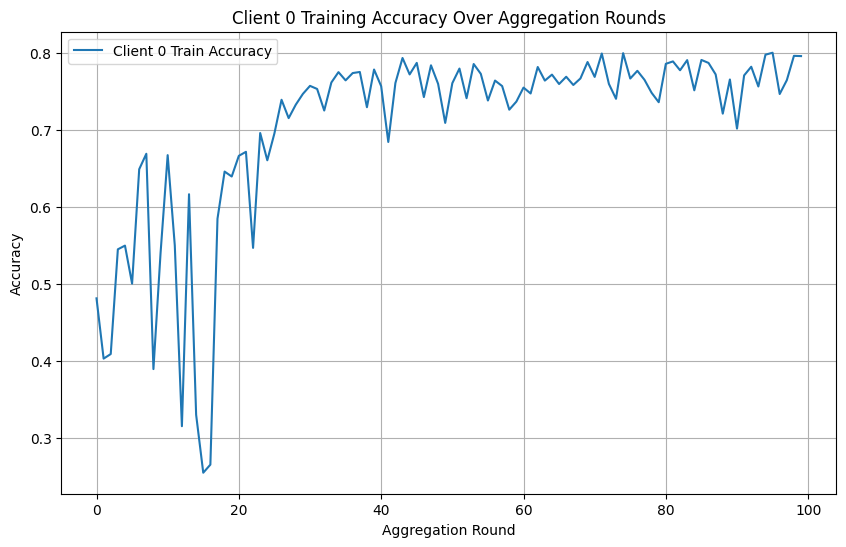

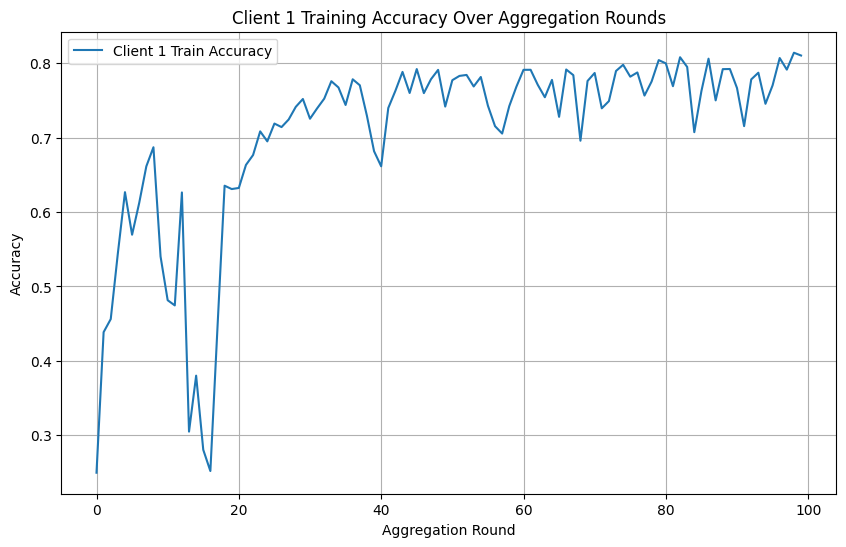

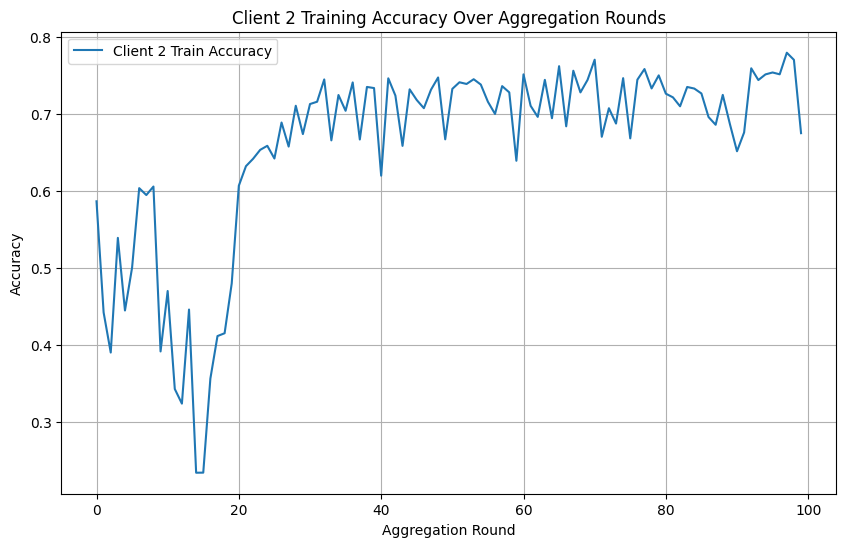

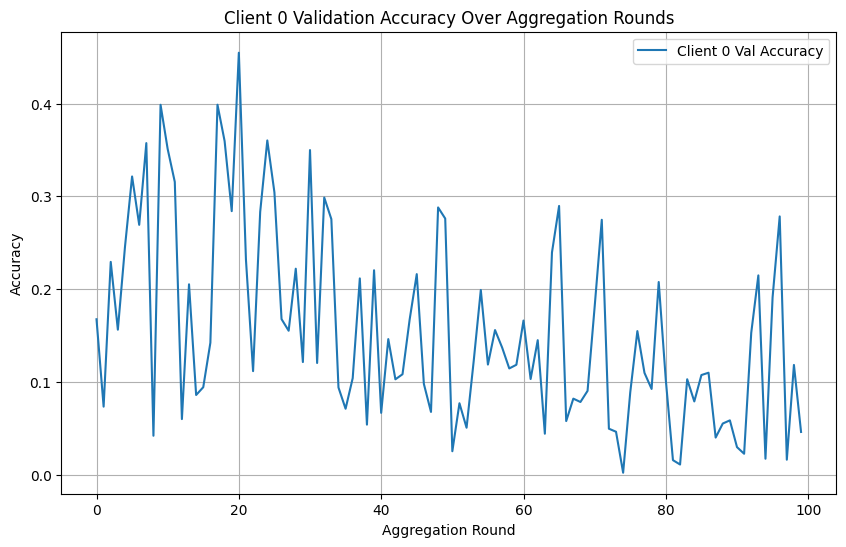

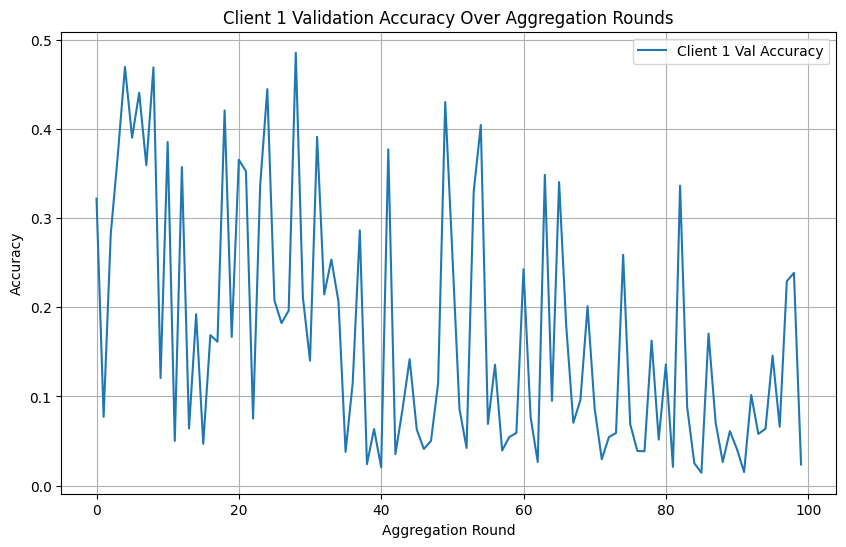

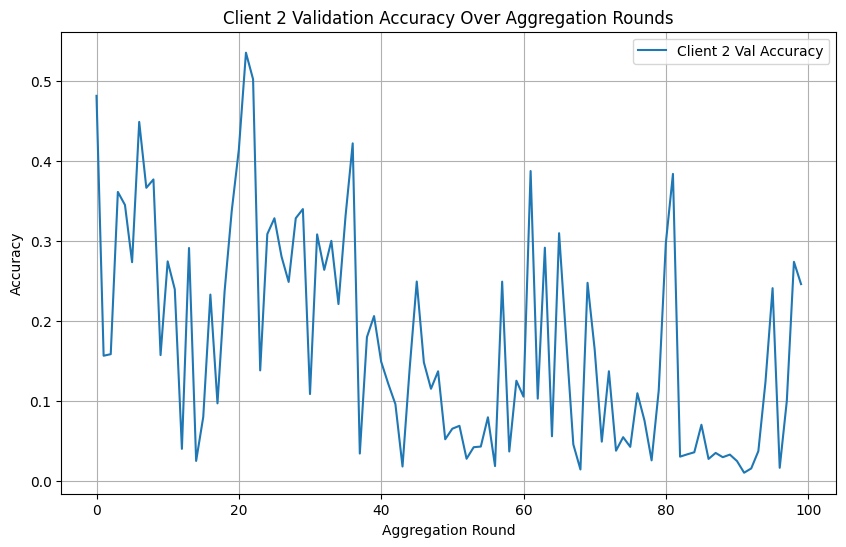

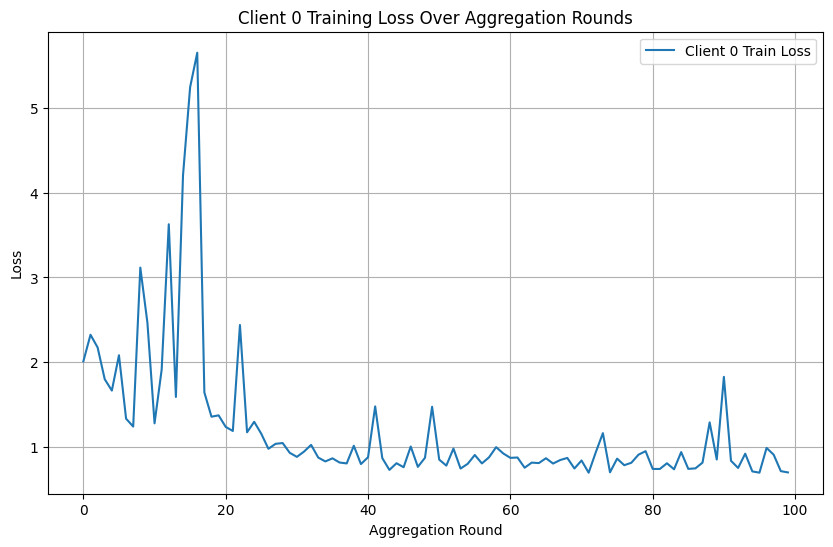

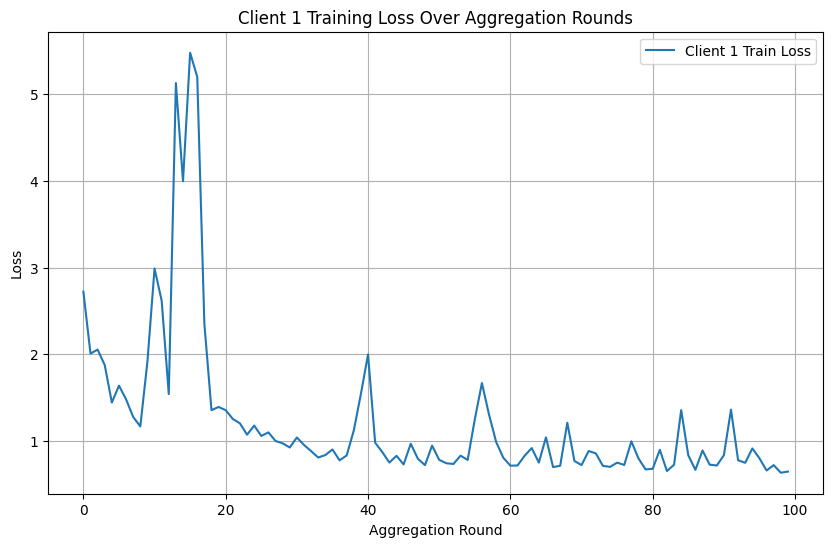

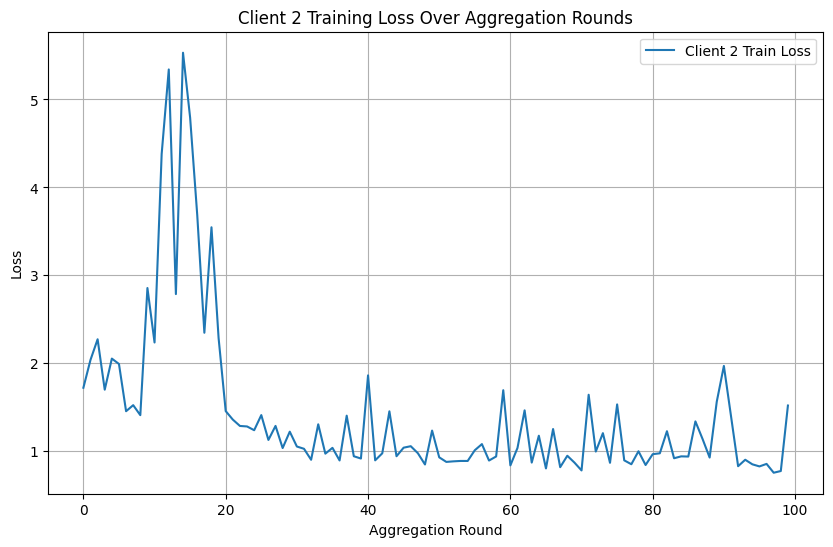

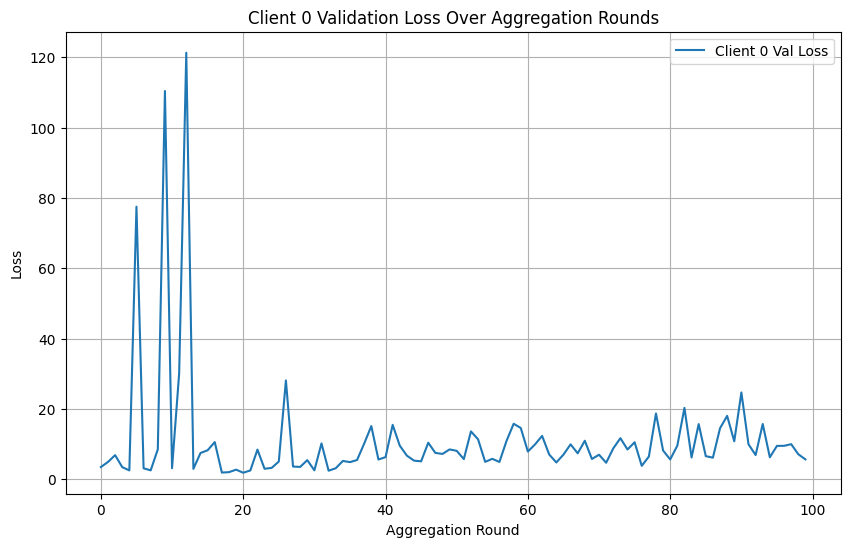

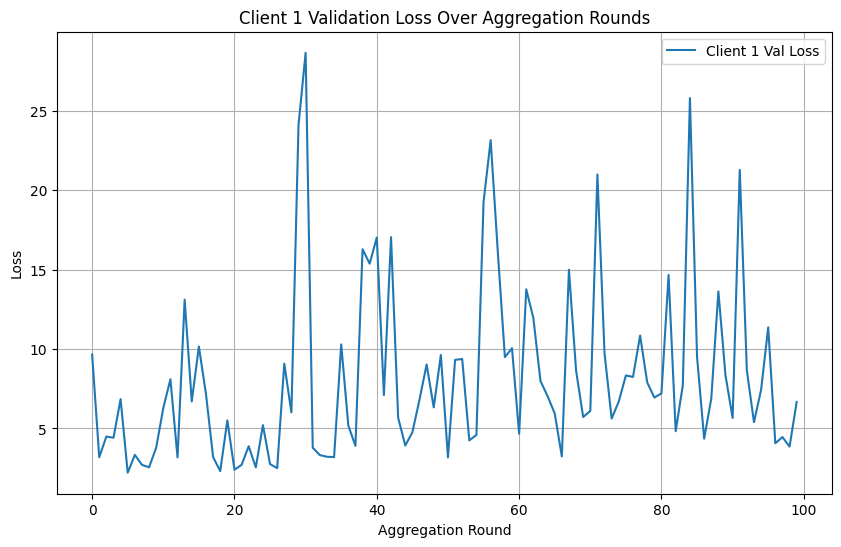

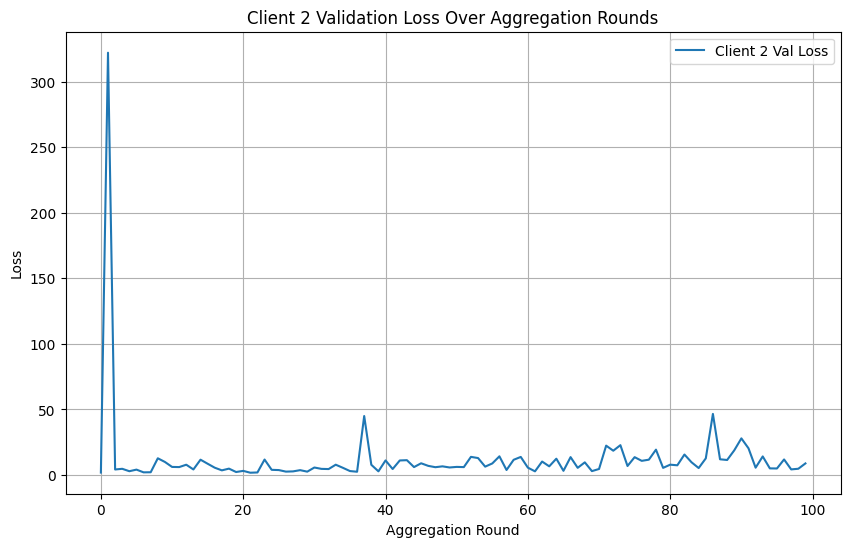

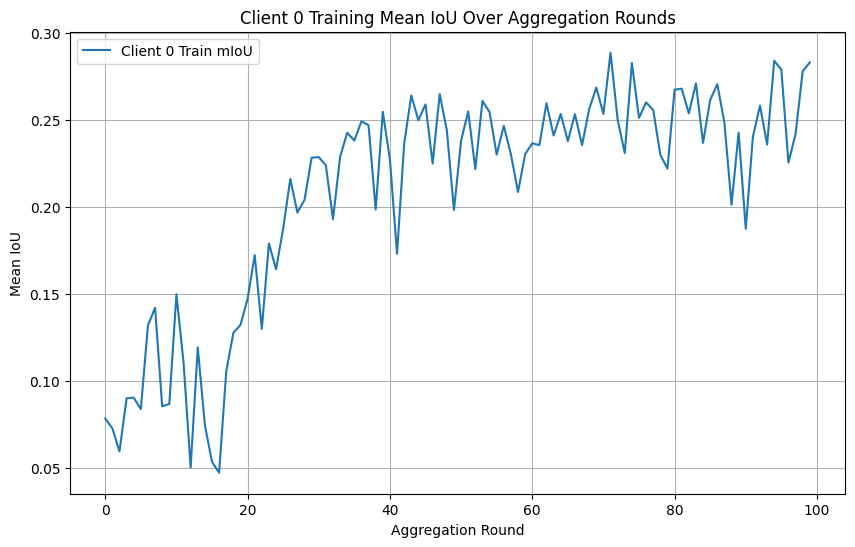

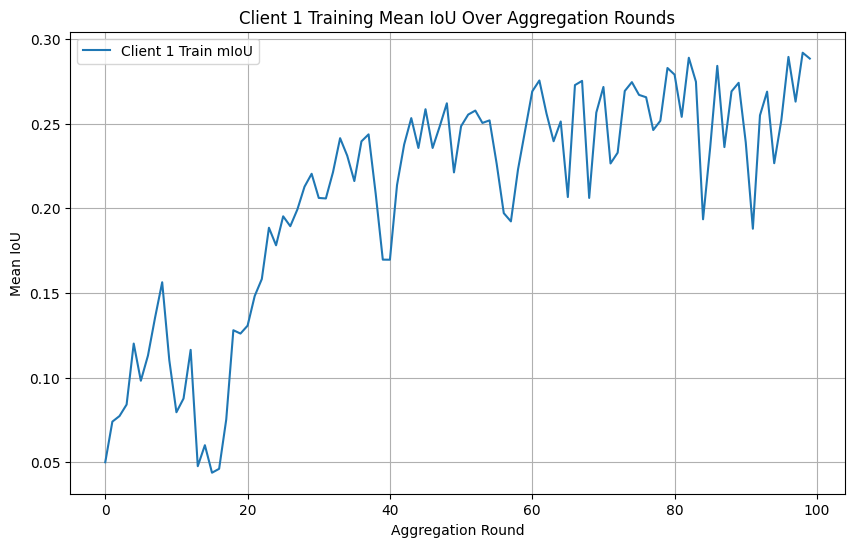

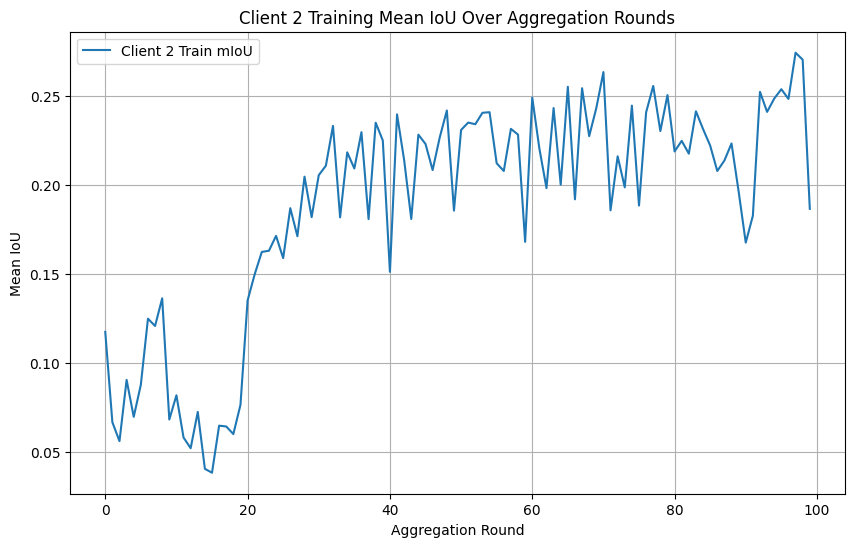

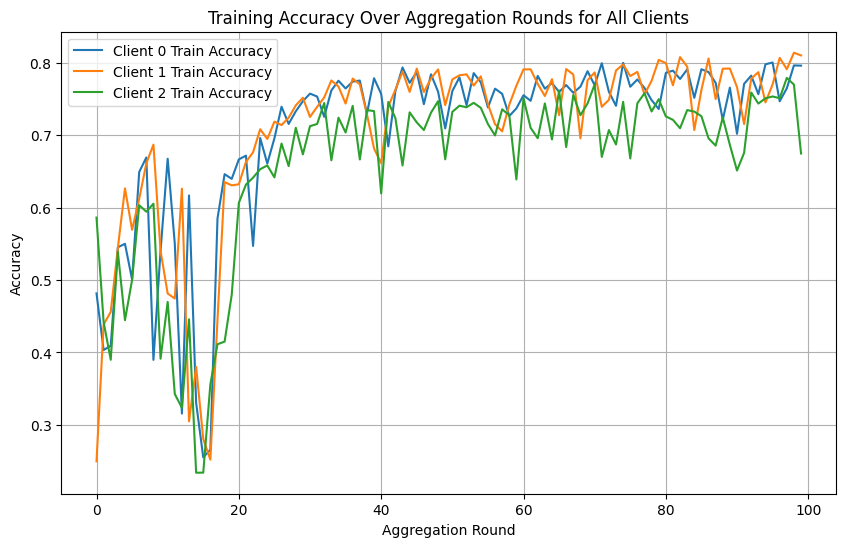

Aggregation Round 1 histories:
  Client 0: {'train_loss': [2.009375127507191], 'val_loss': [3.467248605357276], 'train_miou': [0.0782878623445485], 'val_miou': [0.019774414688026216], 'train_acc': [0.48163889215939476], 'val_acc': [0.16744093694999235], 'lrs': [0.0003999999999999993, 0.00042700970536526696, 0.0005077348530511047, 0.0006412669587014461, 0.0008261032461369475, 0.001060163559664094, 0.001340813774238685, 0.0016648954400247402, 0.0020287613277276094, 0.0024283164746725684, 0.0028590642696945546, 0.0033161570581976144, 0.003794450697872558, 0.004288562451100344, 0.004792931562517556, 0.005301881840001393, 0.005809685534785018, 0.006310627801793639, 0.006799071014761876, 0.007269518212327256, 0.007716674961074713, 0.008135508939322678, 0.008521306571092223, 0.008869726072898045, 0.009176846316370443, 0.009439210956806126, 0.009653867331023245, 0.009818399686762477, 0.009930956369669001, 0.0099902706618919, 0.009999225626708713, 0.009990516681618647, 0.009972147738762083, 0.0

In [278]:
import matplotlib.pyplot as plt

# Initialize dictionaries to store accuracies, losses, and mIoU for each client
train_accuracies = {i: [] for i in range(no_clients)}
val_accuracies = {i: [] for i in range(no_clients)}
train_losses = {i: [] for i in range(no_clients)}
val_losses = {i: [] for i in range(no_clients)}
train_miou = {i: [] for i in range(no_clients)}
val_miou = {i: [] for i in range(no_clients)}

# Populate the dictionaries with data from histories
for epoch_histories in histories:
	for i, history in enumerate(epoch_histories):
		train_accuracies[i].append(history["train_acc"][-1])
		val_accuracies[i].append(history["val_acc"][-1])
		train_losses[i].append(history["train_loss"][-1])
		val_losses[i].append(history["val_loss"][-1])
		train_miou[i].append(history["train_miou"][-1])
		val_miou[i].append(history["val_miou"][-1])

# Plotting training accuracy for each client independently
for i in range(no_clients):
	plt.figure(figsize=(10, 6))
	plt.plot(train_accuracies[i], label=f"Client {i} Train Accuracy")
	plt.xlabel("Aggregation Round")
	plt.ylabel("Accuracy")
	plt.title(f"Client {i} Training Accuracy Over Aggregation Rounds")
	plt.legend()
	plt.grid(True)
	plt.show()

# Plotting validation accuracy for each client independently
for i in range(no_clients):
	plt.figure(figsize=(10, 6))
	plt.plot(val_accuracies[i], label=f"Client {i} Val Accuracy")
	plt.xlabel("Aggregation Round")
	plt.ylabel("Accuracy")
	plt.title(f"Client {i} Validation Accuracy Over Aggregation Rounds")
	plt.legend()
	plt.grid(True)
	plt.show()

# Plotting training loss for each client independently
for i in range(no_clients):
	plt.figure(figsize=(10, 6))
	plt.plot(train_losses[i], label=f"Client {i} Train Loss")
	plt.xlabel("Aggregation Round")
	plt.ylabel("Loss")
	plt.title(f"Client {i} Training Loss Over Aggregation Rounds")
	plt.legend()
	plt.grid(True)
	plt.show()

# Plotting validation loss for each client independently
for i in range(no_clients):
	plt.figure(figsize=(10, 6))
	plt.plot(val_losses[i], label=f"Client {i} Val Loss")
	plt.xlabel("Aggregation Round")
	plt.ylabel("Loss")
	plt.title(f"Client {i} Validation Loss Over Aggregation Rounds")
	plt.legend()
	plt.grid(True)
	plt.show()

# Plotting mean IoU for each client independently
for i in range(no_clients):
	plt.figure(figsize=(10, 6))
	plt.plot(train_miou[i], label=f"Client {i} Train mIoU")
	plt.xlabel("Aggregation Round")
	plt.ylabel("Mean IoU")
	plt.title(f"Client {i} Training Mean IoU Over Aggregation Rounds")
	plt.legend()
	plt.grid(True)
	plt.show()

# Plotting all clients together for training accuracy
plt.figure(figsize=(10, 6))
for i in range(no_clients):
	plt.plot(train_accuracies[i], label=f"Client {i} Train Accuracy")
plt.xlabel("Aggregation Round")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Aggregation Rounds for All Clients")
plt.legend()
plt.grid(True)
plt.show()

# Display the detailed history for each client and each aggregation round
for e, epoch_histories in enumerate(histories):
	print(f"Aggregation Round {e+1} histories:")
	for i, history in enumerate(epoch_histories):
		print(f"  Client {i}: {history}")

In [279]:
class DroneTestDataset(Dataset):

	def __init__(self, img_path, mask_path, X, transform=None):
		self.img_path = img_path
		self.mask_path = mask_path
		self.X = X
		self.transform = transform

	def __len__(self):
		return len(self.X)

	def __getitem__(self, idx):
		img_full_path = os.path.join(self.img_path, self.X[idx] + ".jpg")
		mask_full_path = os.path.join(self.mask_path, self.X[idx] + ".png")

		img = cv2.imread(img_full_path)
		if img is None:
			raise FileNotFoundError(f"Image not found at {img_full_path}")

		mask = cv2.imread(mask_full_path, cv2.IMREAD_GRAYSCALE)
		if mask is None:
			raise FileNotFoundError(f"Mask not found at {mask_full_path}")

		img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

		if self.transform is not None:
			aug = self.transform(image=img, mask=mask)
			img = Image.fromarray(aug["image"])
			mask = aug["mask"]

		if self.transform is None:
			img = Image.fromarray(img)

		mask = torch.from_numpy(mask).long()

		return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [280]:
def predict_image_mask_miou(
	model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
):
	model.eval()
	t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
	image = t(image)
	model.to(device)
	image = image.to(device)
	mask = mask.to(device)
	with torch.no_grad():

		image = image.unsqueeze(0)
		mask = mask.unsqueeze(0)

		output = model(image)
		score = mIoU(output, mask)
		masked = torch.argmax(output, dim=1)
		masked = masked.cpu().squeeze(0)
	return masked, score

In [281]:
def predict_image_mask_pixel(
	model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
):
	model.eval()
	t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
	image = t(image)
	model.to(device)
	image = image.to(device)
	mask = mask.to(device)
	with torch.no_grad():

		image = image.unsqueeze(0)
		mask = mask.unsqueeze(0)

		output = model(image)
		acc = pixel_accuracy(output, mask)
		masked = torch.argmax(output, dim=1)
		masked = masked.cpu().squeeze(0)
	return masked, acc

In [282]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [283]:
def miou_score(model, test_set):
	score_iou = []
	for i in tqdm(range(len(test_set))):
		img, mask = test_set[i]
		pred_mask, score = predict_image_mask_miou(model, img, mask)
		score_iou.append(score)
	return score_iou

In [284]:
mob_miou = miou_score(model, test_set)

100%|██████████| 40/40 [00:18<00:00,  2.18it/s]


In [285]:
def pixel_acc(model, test_set):
	accuracy = []
	for i in tqdm(range(len(test_set))):
		img, mask = test_set[i]
		pred_mask, acc = predict_image_mask_pixel(model, img, mask)
		accuracy.append(acc)
	return accuracy

In [286]:
mob_acc = pixel_acc(model, test_set)

100%|██████████| 40/40 [00:17<00:00,  2.33it/s]


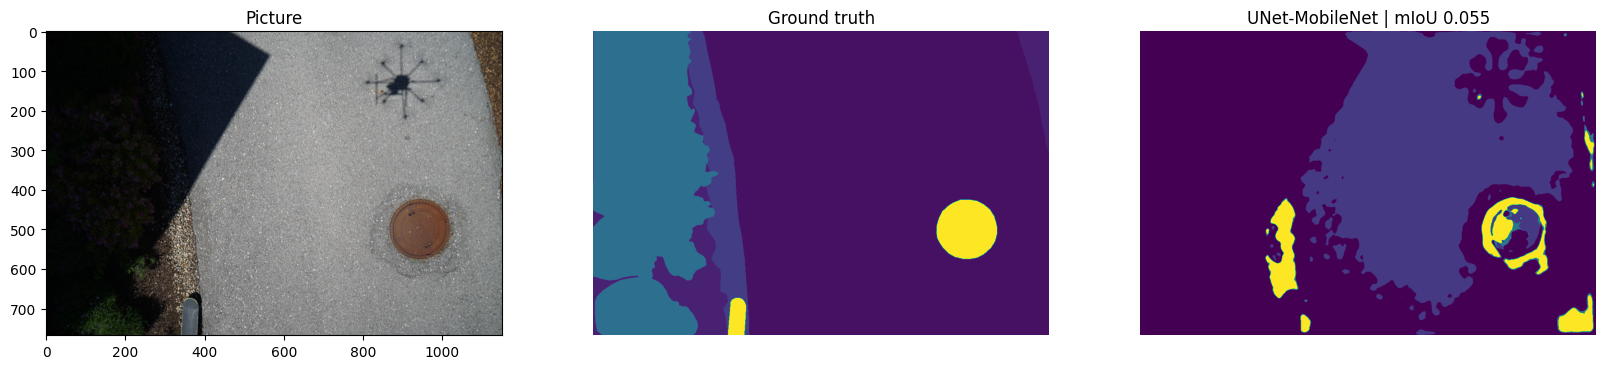

In [287]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(image)
ax1.set_title("Picture")

ax2.imshow(mask)
ax2.set_title("Ground truth")
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title("UNet-MobileNet | mIoU {:.3f}".format(score))
ax3.set_axis_off()

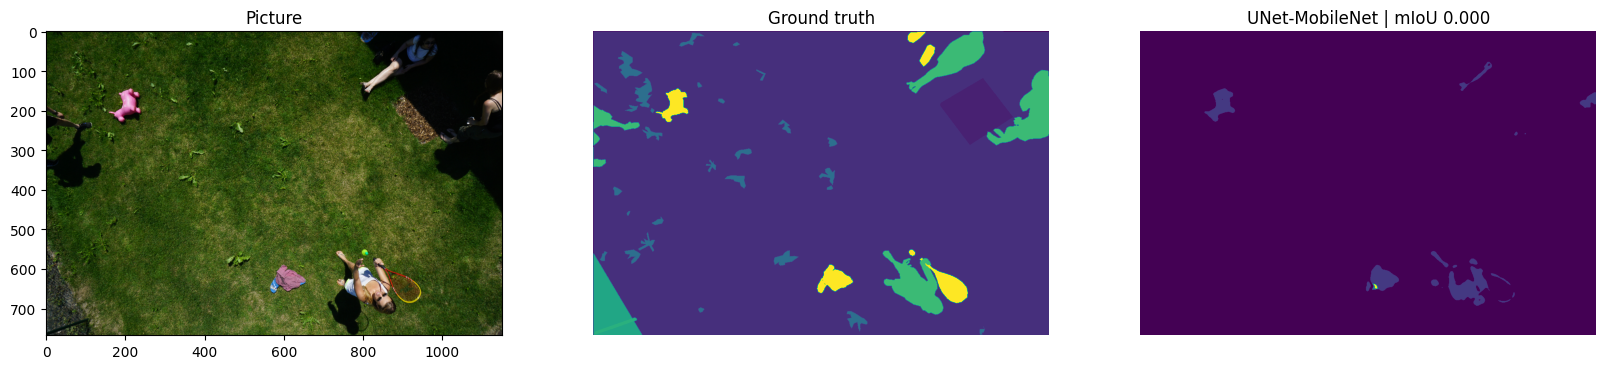

In [288]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(image3)
ax1.set_title("Picture")

ax2.imshow(mask3)
ax2.set_title("Ground truth")
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title("UNet-MobileNet | mIoU {:.3f}".format(score3))
ax3.set_axis_off()

In [289]:
print("Test Set mIoU", np.mean(mob_miou))

Test Set mIoU 0.025218967902572758


In [290]:
print("Test Set Pixel Accuracy", np.mean(mob_acc))

Test Set Pixel Accuracy 0.21884700633861404
